In [ ]:
Turn off my phoneimport time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [ ]:
DEVICE

'cuda'

In [ ]:
# Where do I want to run my job. You can do "cuda" on linux machines
#DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else  "cpu"

# The batch size in Adam or SGD
BATCH_SIZE = 512

# Number of epochs
NUM_EPOCHS = 10

# Predict from 2 words the inner word for CBOW
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word)
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram
# For CBOW, we'll use ["a", "c"] to predict "b" = wo
WINDOW = 1

# Negative samples.
K = 4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir=f'/content/gdrive/My Drive/text8.txt'
f = open(dir, 'r')
text = f.read()
# One big string of size 100M
print(len(text))

Mounted at /content/gdrive
100000000


The text8 Wikipedia corpus. 100M characters.

In [ ]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [ ]:
# A very crude tokenizer you get for free: lower case and also split on spaces
TOKENIZER = get_tokenizer("basic_english")

In [ ]:
words = TOKENIZER(text)
f = Counter(words)

In [ ]:
len(words)

17005207

In [ ]:
# Do a very crude filter on the text which removes all very popular words
text = [word for word in words if f[word] > 5]

In [ ]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [ ]:
VOCAB = build_vocab_from_iterator([text])

In [ ]:
# word -> int hash map
stoi = VOCAB.get_stoi()
# int -> word hash map
itos = VOCAB.get_itos()

In [ ]:
stoi['as']

11

In [ ]:
# Total number of words
len(stoi)

63641

In [ ]:
f = Counter(text)
# This is the probability that we pick a word in the corpus
z = {word: f[word] / len(text) for word in f}

In [ ]:
threshold = 1e-5
# Probability that word is kept while subsampling
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [ ]:
# This is in the integer space
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary
VOCAB = build_vocab_from_iterator([train_dataset])

In [ ]:
len(train_dataset)

7847137

In [ ]:
# word -> int mapping
stoi = VOCAB.get_stoi()
# int -> word mapping
itos = VOCAB.get_itos()

In [ ]:
# The vocabulary size after we do all the filters
len(VOCAB)

63641

In [ ]:
# The probability we draw something for negative sampling
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent
s = sum([np.power(freq, 0.75) for word, freq in f.items()])

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [ ]:
# Map everything to integers
train_dataset = [stoi[word] for word in text]

In [ ]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []

    for i, token in enumerate(dataset):
        m = 1

        # Get the left and right tokens
        start = i +m
        left_tokens = dataset[i: start]

        end = start + 1 +m
        right_tokens = dataset[start +1: end]

        # Check these are the same length, and if so use them to add a row of data. This should be a list like
        # [a, c, b] where b is the center word
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens+right_tokens

            wc =  dataset[start:start +1]

            x_list.extend(
                [w_context+wc]
            )

    return x_list

In [ ]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [ ]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [ ]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [ ]:
# These are (wc, wo) pairs. All are y = +1 by design
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 174, 5],
 [5, 1, 174],
 [174, 3133, 1],
 [1, 49, 3133],
 [3133, 58, 49],
 [49, 149, 58],
 [58, 135, 149],
 [149, 741, 135]]

In [ ]:
# The number of things of BATCH_SIZE = 512
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [ ]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [ ]:
for xb in train_dl:
    print(xb)
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

[tensor([[ 1080, 18693,     6],
        [   91, 23810,    28],
        [ 5698,     3,    27],
        ...,
        [    1,    74,     0],
        [  662,   189,     1],
        [ 1452,  1288,  2792]], device='cuda:0')]


### Words we'll use to asses the quality of the model ...

In [ ]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [ ]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size
        # x is (N, 3)

        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is N
        w_context, wc = x[:, 0:2],x[:,2:]

        # Each of these is (N, 2, D) since each context has 2 word
        # We want this to be (N, D) and this is what we get

        # (N, 2, D)
        a = self.A(w_context)

        # (N, D)
        a_avg = a.sum(axis=1)/2

        # Each of these is (N, D) since each target has 1 word
        b =  self.B(wc)
        b=b.squeeze()

        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a_avg * b).sum(axis=-1)

        return logits

In [ ]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight

    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V)
    # We do S x d (d x V) => S x D and sort by negative similarity
    top_k = 10 # Top k items will be displayed
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [ ]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [ ]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [ ]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [ ]:
validate_embeddings(model, valid_ids, itos)

money: cohn, lip, sibling, antipodes, myasthenia, ub, trail, rodin, absorbing, edgeworth
lion: lockwood, splitflag, initiator, impeding, foe, environments, rewarming, experiments, bureaucrats, navigators
africa: suggests, intuitionism, haskell, if, ogura, widget, prediction, lookups, clogged, narration
musician: sef, airing, droves, complaint, stainless, styled, rocky, eddic, ward, lighters
dance: brion, pataca, valderrama, launching, persisting, combs, talia, inspirational, kitchen, remainder




### Train the model

In [ ]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500

    for idx, x_batch in tqdm(enumerate(dataloader)):


      x_batch = x_batch[0]

      batch_size = x_batch.shape[0]

      # Zero the gradient so they don't accumulate
      optimizer.zero_grad()

      logits = model(x_batch)
          # Get the positive samples loss. Notice we use weights here
      positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())

      # For each batch, get some negative samples
      # We need a total of len(y_batch) * K samples across a batch
      # We then reshape this batch
      # These are effectively the output words
      negative_samples = torch.multinomial(p, batch_size * K, replacement=True)

      # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, )
      w_context, wc = x_batch[:, 0:2].to("cpu"),x_batch[:,2:].to("cpu")
          # Repeat does not work on MPS apparently
        # wc = x_batch[:, 0].to("cpu").repeat(K).sort().values
        #  wo = negative_samples
      """
      if w_context looks like below (batch_size = 3)
      [
      (a, b),
      (c, d),
      (e, f)
      ] and K = 2 we'd like to get:

      [
      (a, b),
      (a, b),
      (c, d),
      (c, d),
      (e, f),
      (e, f)
      ]

      This will be batch_size * K rows.
      """
      # This should be (N * K, 2)
      w_context = torch.concat([
          w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
      ])

      # Add a last dimension and set wc to the negative samples
      wc = negative_samples.unsqueeze(1)

      # Get the negative samples. This should be (N * K, 3)
      # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU
      x_batch_negative =  torch.hstack([w_context,wc]).to(DEVICE)

      """ Numbers
      Note the way we formulated the targets: they are all 0 since these are negative samples.
      We do the BCEWithLogitsLoss by hand basically here.
      Notice we sum across the negative samples, per positive word.

      This is literally the equation in the lecture notes.
      """

      # (N, K, D) -> (N, D) -> (N)
      # Look at the Skip-Gram notebook

      negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
              batch_size, K
          ).sum(1).mean().neg().to(DEVICE)

      loss = (positive_loss + negative_loss).mean()


      # Get the gradients via back propagation
      loss.backward()

      # Clip the gradients? Generally a good idea
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

      # Used for optimization. This should be roughly 0.001, on average
      # You can use this to see if your learning rate is right - you can also plot the loss performance
      # with torch.no_grad():
      #     r = [
      #         (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
      #     ]
      #     ratios.append(r)

      # Do an optimization step. Update the parameters A and B amethyst look at it the rest of them though wrong with that million hours waiting for it to load each time
      optimizer.step()
      # Get the new loss.
      total_loss += loss.item()
      # Update the batch count
      total_batches += 1

      if idx % log_interval == 0:
          print(
              "| epoch {:3d} | {:5d}/{:5d} batches "
              "| loss {:8.3f} ".format(
                  epoch,
                  idx,
                  len(dataloader),
                  total_loss / total_batches
              )
          )
          validate_embeddings(model, valid_ids, itos)
          total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [ ]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()

    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way
    scheduler.step()

0it [00:00, ?it/s]<ipython-input-41-8a48dceb148f>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)


| epoch   1 |     0/32580 batches | loss    4.102 


7it [00:02,  4.21it/s]

money: flanker, coronation, unnavigable, monckton, foramen, powermac, emmerson, rightly, macc, mapuche
lion: prophesied, caria, duh, lieder, lazio, jagiellon, gangster, insider, liberians, flotilla
africa: shebaa, yasser, peerage, obrzeg, westbound, deemed, hotham, geertz, algerian, zwicky
musician: isiah, fliers, alicante, moorland, fountainhead, kodokan, penetrated, duty, beached, penetrating
dance: coniferous, sliding, lusaka, forge, hygiene, conyers, meher, mordecai, shaughnessy, chaff




497it [00:09, 63.98it/s]

| epoch   1 |   500/32580 batches | loss    3.718 


510it [00:10, 43.27it/s]

money: flanker, unnavigable, powermac, monckton, foramen, coronation, emmerson, reminds, macc, rightly
lion: prophesied, duh, caria, lieder, lazio, gangster, jagiellon, insider, flotilla, liberians
africa: shebaa, yasser, obrzeg, peerage, westbound, hotham, deemed, zwicky, cosmonaut, machete
musician: isiah, fliers, alicante, moorland, fountainhead, penetrating, penetrated, kodokan, vaud, pheromones
dance: forge, coniferous, lusaka, hygiene, sliding, conyers, cycled, meher, chaff, referrals




995it [00:18, 63.57it/s]

| epoch   1 |  1000/32580 batches | loss    3.352 


1008it [00:19, 42.87it/s]

money: powermac, flanker, monckton, coronation, foramen, unnavigable, emmerson, reminds, macc, rightly
lion: prophesied, caria, duh, lieder, lazio, jagiellon, gangster, insider, liberians, flotilla
africa: shebaa, yasser, obrzeg, westbound, peerage, cosmonaut, deemed, hotham, marshes, machete
musician: isiah, fliers, alicante, penetrating, moorland, fountainhead, kodokan, vaud, pheromones, penetrated
dance: forge, coniferous, lusaka, sliding, hygiene, conyers, meher, chaff, cycled, shaughnessy




1498it [00:27, 48.15it/s]

| epoch   1 |  1500/32580 batches | loss    3.023 


1508it [00:28, 30.43it/s]

money: powermac, flanker, monckton, coronation, unnavigable, emmerson, reminds, foramen, macc, mapuche
lion: prophesied, caria, duh, lieder, jagiellon, lazio, gangster, insider, liberians, flotilla
africa: shebaa, westbound, obrzeg, yasser, cosmonaut, own, peerage, zwicky, marshes, claims
musician: isiah, fliers, alicante, penetrating, moorland, fountainhead, vaud, kodokan, candlemas, beached
dance: forge, coniferous, lusaka, chaff, hygiene, sliding, database, conyers, meher, cycled




1999it [00:35, 63.89it/s]

| epoch   1 |  2000/32580 batches | loss    2.788 


2006it [00:36, 38.44it/s]

money: powermac, monckton, flanker, coronation, emmerson, reminds, unnavigable, macc, foramen, ransoming
lion: prophesied, caria, duh, jagiellon, lieder, lazio, gangster, insider, flotilla, till
africa: shebaa, own, westbound, cosmonaut, obrzeg, marshes, claims, yasser, zwicky, peerage
musician: isiah, fliers, alicante, penetrating, vaud, fountainhead, moorland, candlemas, orfeo, kodokan
dance: forge, coniferous, database, chaff, hygiene, sliding, lusaka, conyers, meher, cycled




2498it [00:44, 63.21it/s]

| epoch   1 |  2500/32580 batches | loss    2.615 


2512it [00:45, 43.04it/s]

money: monckton, powermac, emmerson, work, flanker, coronation, reminds, unnavigable, macc, foramen
lion: prophesied, duh, caria, jagiellon, lieder, lazio, insider, gangster, flotilla, liberians
africa: that, own, not, cosmonaut, claims, most, westbound, shebaa, often, obrzeg
musician: isiah, fliers, alicante, penetrating, candlemas, vaud, fountainhead, orfeo, moorland, pheromones
dance: database, coniferous, forge, chaff, hygiene, lusaka, sliding, conyers, cycled, meher




3000it [00:53, 54.52it/s]

| epoch   1 |  3000/32580 batches | loss    2.481 


3006it [00:53, 29.42it/s]

money: work, powermac, monckton, emmerson, flanker, reminds, coronation, macc, foramen, unnavigable
lion: prophesied, caria, jagiellon, duh, lieder, lazio, insider, gangster, flotilla, till
africa: that, own, often, more, not, most, this, be, is, cosmonaut
musician: isiah, fliers, alicante, penetrating, candlemas, fountainhead, vaud, orfeo, pheromones, kodokan
dance: database, coniferous, forge, hygiene, lusaka, sliding, chaff, conyers, cycled, thais




3499it [01:01, 64.24it/s]

| epoch   1 |  3500/32580 batches | loss    2.379 


3506it [01:02, 38.37it/s]

money: work, powermac, monckton, flanker, emmerson, coronation, reminds, it, time, games
lion: prophesied, caria, jagiellon, duh, lieder, lazio, insider, gangster, flotilla, till
africa: that, often, not, own, more, all, most, this, other, but
musician: isiah, fliers, alicante, penetrating, candlemas, orfeo, community, fountainhead, vaud, kodokan
dance: database, coniferous, forge, hygiene, sliding, lusaka, no, chaff, conyers, black




3995it [01:10, 63.37it/s]

| epoch   1 |  4000/32580 batches | loss    2.292 


4008it [01:11, 43.17it/s]

money: work, it, time, but, games, may, u, he, powermac, years
lion: prophesied, lieder, caria, duh, jagiellon, insider, lazio, gangster, flotilla, till
africa: often, that, own, more, not, all, other, most, used, over
musician: isiah, fliers, alicante, penetrating, candlemas, community, orfeo, vaud, fountainhead, male
dance: database, no, coniferous, forge, hygiene, a, history, sliding, lusaka, chaff




4498it [01:18, 64.62it/s]

| epoch   1 |  4500/32580 batches | loss    2.218 


4512it [01:19, 44.00it/s]

money: work, it, time, but, u, he, games, out, which, they
lion: prophesied, lieder, jagiellon, caria, duh, insider, lazio, gangster, flotilla, till
africa: often, all, that, not, more, own, used, other, which, over
musician: isiah, fliers, community, candlemas, penetrating, alicante, orfeo, male, fountainhead, vaud
dance: no, database, a, history, coniferous, its, black, forge, some




4995it [01:27, 61.43it/s]

| epoch   1 |  5000/32580 batches | loss    2.159 


5008it [01:28, 41.83it/s]

money: work, time, it, u, out, which, games, may, but, life
lion: prophesied, lieder, jagiellon, caria, duh, insider, lazio, gangster, flotilla, till
africa: often, all, that, used, work, not, history, more, own, over
musician: isiah, fliers, community, penetrating, male, candlemas, alicante, orfeo, setting, fountainhead
dance: no, database, history, black, some, its, coniferous, first, church




5497it [01:37, 52.55it/s]

| epoch   1 |  5500/32580 batches | loss    2.103 


5509it [01:37, 38.83it/s]

money: work, time, it, out, u, life, which, games, years, they
lion: prophesied, jagiellon, lieder, caria, duh, insider, lazio, flotilla, till, gangster
africa: often, all, used, work, not, history, that, own, many, which
musician: isiah, community, fliers, male, penetrating, candlemas, orfeo, set, setting, signed
dance: no, database, history, some, black, a, first, church, its




5999it [01:45, 62.42it/s]

| epoch   1 |  6000/32580 batches | loss    2.057 


6006it [01:45, 38.32it/s]

money: work, time, it, u, life, out, then, which, years, may
lion: prophesied, lieder, jagiellon, caria, duh, insider, lazio, flotilla, till, gangster
africa: used, all, often, work, not, history, many, because, own, only
musician: isiah, community, male, set, fliers, being, setting, penetrating, candlemas, party
dance: no, history, first, some, black, a, database, church, name, well




6498it [01:54, 62.17it/s]

| epoch   1 |  6500/32580 batches | loss    2.016 


6512it [01:54, 42.44it/s]

money: work, time, u, life, it, then, but, out, years, may
lion: prophesied, jagiellon, caria, lieder, insider, duh, lazio, flotilla, till, farinelli
africa: used, all, work, often, only, not, history, because, found, many
musician: isiah, set, community, male, party, being, setting, finally, found, fliers
dance: no, history, black, first, church, name, database, second, well




6996it [02:02, 47.17it/s]

| epoch   1 |  7000/32580 batches | loss    1.978 


7005it [02:03, 27.36it/s]

money: work, time, then, u, life, it, years, out, games, but
lion: prophesied, jagiellon, lieder, caria, duh, insider, lazio, flotilla, farinelli, till
africa: used, all, work, history, only, often, because, found, own, time
musician: set, community, isiah, being, found, party, male, them, role, finally
dance: no, history, black, first, church, with, its, name, some




7497it [02:11, 64.62it/s]

| epoch   1 |  7500/32580 batches | loss    1.945 


7510it [02:11, 43.29it/s]

money: work, time, then, u, it, life, out, years, games, used
lion: prophesied, jagiellon, lieder, caria, insider, duh, flotilla, lazio, till, farinelli
africa: used, all, work, history, time, only, found, because, part, often
musician: set, community, found, being, party, them, role, male, form, social
dance: no, history, name, first, church, black, second, well, any, its




7998it [02:20, 63.92it/s]

| epoch   1 |  8000/32580 batches | loss    1.912 


8012it [02:20, 42.29it/s]

money: work, time, then, u, out, life, it, use, years, used
lion: prophesied, jagiellon, lieder, caria, insider, duh, flotilla, lazio, farinelli, till
africa: used, work, all, history, part, found, eight, because, time, often
musician: set, found, community, party, them, being, role, form, male, social
dance: no, history, first, name, black, well, church, second, same




8499it [02:28, 48.26it/s]

| epoch   1 |  8500/32580 batches | loss    1.890 


8509it [02:29, 29.03it/s]

money: work, time, u, then, it, life, out, use, information, used
lion: prophesied, jagiellon, caria, lieder, insider, duh, flotilla, till, farinelli, lazio
africa: work, used, history, part, found, all, because, which, form, however
musician: set, found, party, them, role, form, being, community, point, b
dance: no, history, name, black, church, well, first, second, same




8997it [02:37, 64.20it/s]

| epoch   1 |  9000/32580 batches | loss    1.862 


9010it [02:38, 42.78it/s]

money: work, time, u, life, then, use, out, information, it, so
lion: prophesied, jagiellon, caria, lieder, insider, duh, farinelli, lazio, till, flotilla
africa: work, used, history, part, found, because, form, all, only, time
musician: set, found, party, form, role, being, community, them, point, social
dance: no, history, name, black, first, well, same, music, second, church




9497it [02:46, 64.60it/s]

| epoch   1 |  9500/32580 batches | loss    1.837 


9510it [02:47, 42.79it/s]

money: work, time, u, then, life, use, god, it, information, out
lion: prophesied, jagiellon, caria, lieder, insider, farinelli, flotilla, sravaka, duh, till
africa: work, used, part, history, found, form, time, europe, because, u
musician: set, found, form, party, them, role, name, used, community, being
dance: history, no, name, black, music, well, church, first, time, second




10000it [02:54, 64.31it/s]

| epoch   1 | 10000/32580 batches | loss    1.816 


10007it [02:55, 38.31it/s]

money: work, time, u, life, then, use, god, what, out, even
lion: prophesied, jagiellon, lieder, caria, insider, sravaka, till, farinelli, flotilla, duh
africa: work, used, part, found, form, history, time, u, end, europe
musician: set, found, form, them, party, name, role, germany, both, emperor
dance: history, no, name, black, music, well, church, second, form, same




10498it [03:03, 64.41it/s]

| epoch   1 | 10500/32580 batches | loss    1.797 


10511it [03:04, 43.12it/s]

money: work, time, u, then, use, god, life, what, out, even
lion: prophesied, jagiellon, lieder, insider, caria, sravaka, till, railhead, farinelli, flotilla
africa: work, used, part, found, form, end, history, order, europe, u
musician: set, found, form, them, name, both, role, party, social, emperor
dance: history, no, name, black, well, church, second, country, music, same




11000it [03:12, 60.14it/s]

| epoch   1 | 11000/32580 batches | loss    1.774 


11007it [03:13, 36.51it/s]

money: work, time, u, then, life, god, what, use, made, even
lion: prophesied, insider, lieder, jagiellon, caria, sravaka, till, railhead, convention, farinelli
africa: work, part, used, found, form, europe, end, history, u, because
musician: set, found, form, name, role, party, emperor, used, part, result
dance: history, no, name, black, well, time, church, form, music, country




11497it [03:20, 64.76it/s]

| epoch   1 | 11500/32580 batches | loss    1.760 


11511it [03:21, 43.65it/s]

money: work, time, u, god, then, life, use, what, out, information
lion: prophesied, jagiellon, insider, lieder, convention, caria, till, sravaka, farinelli, railhead
africa: work, part, used, found, form, europe, end, u, history, order
musician: set, form, found, name, emperor, support, role, germany, result, god
dance: history, no, name, black, time, church, music, country, well, second




11994it [03:29, 64.07it/s]

| epoch   1 | 12000/32580 batches | loss    1.742 


12007it [03:30, 43.40it/s]

money: work, time, god, u, life, use, then, what, eight, nine
lion: prophesied, convention, jagiellon, insider, lieder, till, caria, farinelli, sravaka, railhead
africa: work, part, europe, found, used, form, u, history, end, order
musician: set, form, found, name, emperor, germany, result, god, published, role
dance: history, name, no, black, time, music, country, church, same, well




12497it [03:38, 49.40it/s]

| epoch   1 | 12500/32580 batches | loss    1.727 


12507it [03:38, 30.91it/s]

money: work, time, u, god, use, life, then, what, even, result
lion: prophesied, convention, jagiellon, insider, till, lieder, caria, railhead, sravaka, farinelli
africa: work, part, europe, found, form, end, used, u, order, history
musician: set, found, form, name, germany, god, emperor, published, result, republic
dance: history, name, no, music, black, country, time, church, same, well




13000it [03:46, 64.43it/s]

| epoch   1 | 13000/32580 batches | loss    1.711 


13007it [03:47, 38.67it/s]

money: work, time, u, god, use, then, life, even, what, result
lion: prophesied, convention, jagiellon, insider, till, lieder, railhead, caria, sravaka, farinelli
africa: work, part, europe, found, end, used, form, history, order, u
musician: found, set, form, name, result, emperor, england, germany, published, republic
dance: history, name, no, music, country, black, time, church, same, well




13498it [03:55, 64.00it/s]

| epoch   1 | 13500/32580 batches | loss    1.698 


13512it [03:56, 43.22it/s]

money: work, time, god, u, use, then, even, what, life, result
lion: convention, prophesied, insider, jagiellon, till, lieder, consists, railhead, sravaka, caria
africa: work, europe, part, end, found, form, order, used, history, nine
musician: set, found, form, name, result, england, republic, germany, emperor, published
dance: history, name, no, music, country, time, black, church, form, second




13996it [04:03, 49.48it/s]

| epoch   1 | 14000/32580 batches | loss    1.682 


14005it [04:04, 30.68it/s]

money: work, time, god, u, use, even, then, what, result, life
lion: convention, prophesied, consists, insider, lieder, jagiellon, till, sravaka, railhead, concentrations
africa: work, part, europe, end, found, order, form, u, used, nine
musician: found, set, form, result, name, republic, germany, emperor, writer, england
dance: history, name, no, music, country, time, black, second, church, order




14498it [04:12, 64.93it/s]

| epoch   1 | 14500/32580 batches | loss    1.675 


14511it [04:13, 43.17it/s]

money: work, time, god, u, use, what, even, then, result, life
lion: convention, prophesied, consists, insider, till, jagiellon, lieder, sravaka, concentrations, railhead
africa: europe, work, part, end, found, order, u, form, america, used
musician: found, form, set, result, name, writer, republic, germany, england, u
dance: history, name, music, no, country, story, modern, time, black, order




14999it [04:21, 62.07it/s]

| epoch   1 | 15000/32580 batches | loss    1.656 


15006it [04:22, 38.14it/s]

money: work, time, u, god, use, what, even, then, result, life
lion: convention, prophesied, consists, till, insider, lieder, jagiellon, sravaka, concentrations, railhead
africa: europe, work, part, end, found, order, u, america, nine, form
musician: found, form, result, writer, republic, name, set, germany, u, england
dance: history, country, name, music, no, story, church, able, modern, black




15496it [04:29, 64.16it/s]

| epoch   1 | 15500/32580 batches | loss    1.649 


15509it [04:30, 42.75it/s]

money: work, time, god, u, use, what, even, then, result, life
lion: convention, prophesied, consists, till, insider, lieder, jagiellon, sravaka, concentrations, railhead
africa: europe, part, work, end, america, order, found, u, nine, form
musician: form, found, result, writer, name, england, republic, set, germany, u
dance: history, name, country, music, no, story, church, modern, able, order




15994it [04:38, 63.89it/s]

| epoch   1 | 16000/32580 batches | loss    1.638 


16007it [04:39, 42.52it/s]

money: work, time, god, u, use, even, what, then, result, life
lion: convention, consists, prophesied, till, insider, lieder, jagiellon, concentrations, railhead, sravaka
africa: europe, part, work, end, america, order, found, u, nine, form
musician: writer, found, form, result, england, republic, name, emperor, germany, u
dance: history, country, name, music, no, story, able, church, order, modern




16500it [04:47, 58.61it/s]

| epoch   1 | 16500/32580 batches | loss    1.622 


16506it [04:48, 34.74it/s]

money: work, god, time, u, even, use, result, then, life, what
lion: convention, consists, prophesied, till, insider, concentrations, beer, sravaka, lieder, railhead
africa: europe, part, work, end, america, nine, found, order, u, south
musician: found, writer, result, form, england, republic, u, germany, set, civil
dance: history, name, country, music, able, story, no, church, order, black




16996it [04:55, 63.86it/s]

| epoch   1 | 17000/32580 batches | loss    1.616 


17009it [04:56, 43.23it/s]

money: work, time, god, u, even, then, result, use, what, life
lion: convention, consists, prophesied, till, concentrations, insider, euro, beer, navy, hills
africa: europe, part, america, end, work, found, nine, u, order, south
musician: writer, result, found, form, republic, u, england, emperor, germany, name
dance: history, country, name, music, able, story, church, black, order, no




17494it [05:04, 63.44it/s]

| epoch   1 | 17500/32580 batches | loss    1.604 


17507it [05:05, 42.38it/s]

money: work, time, god, u, then, even, result, use, life, what
lion: convention, consists, prophesied, till, concentrations, navy, insider, hills, euro, beer
africa: europe, part, america, end, work, found, u, nine, order, south
musician: writer, result, found, republic, england, u, actor, form, emperor, civil
dance: history, music, country, name, able, no, story, church, black, modern




17996it [05:13, 45.92it/s]

| epoch   1 | 18000/32580 batches | loss    1.593 


18006it [05:13, 30.42it/s]

money: work, god, time, u, result, even, use, then, what, way
lion: convention, consists, prophesied, till, navy, concentrations, hills, euro, beer, railhead
africa: europe, part, america, end, nine, u, work, found, south, order
musician: writer, result, republic, found, u, actor, form, england, eight, january
dance: history, music, country, name, able, story, church, black, no, modern




18497it [05:21, 63.61it/s]

| epoch   1 | 18500/32580 batches | loss    1.586 


18510it [05:22, 42.65it/s]

money: work, god, time, u, result, use, even, then, what, made
lion: convention, consists, prophesied, till, navy, concentrations, hills, beer, measured, euro
africa: europe, america, end, part, u, nine, south, work, order, found
musician: writer, result, u, republic, actor, found, kingdom, form, january, eight
dance: history, music, country, name, able, story, church, no, black, order




18996it [05:30, 64.04it/s]

| epoch   1 | 19000/32580 batches | loss    1.580 


19009it [05:31, 41.30it/s]

money: work, god, time, u, result, use, even, then, what, end
lion: convention, consists, navy, till, prophesied, hills, concentrations, beer, statement, mainly
africa: europe, america, end, part, south, u, nine, china, found, west
musician: writer, result, republic, u, actor, kingdom, january, civil, england, addition
dance: history, music, country, name, able, story, order, church, no, black




19499it [05:39, 50.55it/s]

| epoch   1 | 19500/32580 batches | loss    1.569 


19505it [05:39, 27.51it/s]

money: work, god, time, u, result, then, use, even, end, way
lion: convention, consists, navy, till, prophesied, beer, hills, concentrations, statement, measured
africa: europe, america, end, south, u, part, nine, found, china, north
musician: writer, result, actor, u, republic, kingdom, civil, form, addition, january
dance: history, music, country, name, able, story, order, same, black, science




19995it [05:50, 63.51it/s]

| epoch   1 | 20000/32580 batches | loss    1.562 


20008it [05:51, 42.98it/s]

money: work, god, time, even, result, u, then, use, end, seen
lion: convention, consists, till, navy, prophesied, statement, hills, beer, concentrations, measured
africa: europe, america, end, part, south, germany, nine, north, u, found
musician: writer, result, actor, u, republic, kingdom, civil, addition, form, january
dance: history, music, country, name, able, story, same, order, black, idea




20499it [05:59, 64.36it/s]

| epoch   1 | 20500/32580 batches | loss    1.555 


20506it [06:00, 37.81it/s]

money: work, god, time, result, u, even, then, end, seen, what
lion: convention, consists, navy, statement, hills, till, beer, measured, prophesied, concentrations
africa: europe, america, end, germany, china, part, south, north, west, u
musician: writer, result, actor, u, republic, kingdom, civil, addition, january, form
dance: history, country, music, able, name, story, same, order, science, idea




20997it [06:08, 48.32it/s]

| epoch   1 | 21000/32580 batches | loss    1.546 


21006it [06:09, 28.30it/s]

money: work, god, time, result, even, u, use, what, seen, way
lion: convention, consists, statement, navy, beer, measured, hills, concentrations, till, prophesied
africa: europe, america, end, germany, china, part, south, nine, west, north
musician: writer, result, actor, u, kingdom, republic, addition, civil, singer, form
dance: history, able, country, music, name, story, same, modern, subject, order




21500it [06:16, 64.38it/s]

| epoch   1 | 21500/32580 batches | loss    1.533 


21507it [06:17, 38.72it/s]

money: work, god, result, time, even, u, then, them, what, seen
lion: convention, consists, statement, navy, hills, beer, measured, concentrations, till, prophesied
africa: europe, america, end, germany, china, south, india, part, west, north
musician: writer, actor, result, u, kingdom, republic, singer, addition, civil, march
dance: history, able, country, music, name, story, same, case, idea, subject




21996it [06:25, 62.08it/s]

| epoch   1 | 22000/32580 batches | loss    1.533 


22009it [06:26, 42.56it/s]

money: work, god, time, result, u, even, then, what, seen, them
lion: convention, consists, statement, navy, hills, measured, beer, concentrations, euro, mainly
africa: europe, america, end, germany, china, nine, india, south, part, north
musician: writer, actor, result, u, kingdom, singer, addition, republic, march, january
dance: history, music, able, country, story, name, case, idea, science, same




22497it [06:34, 46.77it/s]

| epoch   1 | 22500/32580 batches | loss    1.520 


22506it [06:35, 28.25it/s]

money: work, god, time, result, even, u, it, what, seen, them
lion: convention, consists, statement, navy, measured, hills, beer, euro, concentrations, question
africa: europe, america, end, china, germany, south, india, nine, part, north
musician: writer, actor, singer, result, kingdom, u, addition, republic, january, march
dance: history, able, music, country, story, name, idea, view, subject, case




22998it [06:43, 57.67it/s]

| epoch   1 | 23000/32580 batches | loss    1.515 


23010it [06:43, 36.88it/s]

money: work, god, time, result, even, u, way, seen, what, it
lion: convention, consists, statement, navy, measured, hills, beer, euro, concentrations, till
africa: europe, america, china, germany, end, nine, india, south, north, part
musician: writer, actor, singer, result, u, kingdom, republic, addition, march, january
dance: history, music, able, country, story, name, idea, same, view, science




23499it [06:52, 63.87it/s]

| epoch   1 | 23500/32580 batches | loss    1.515 


23506it [06:52, 38.47it/s]

money: work, god, result, time, even, it, u, them, seen, way
lion: convention, consists, statement, navy, measured, hills, euro, beer, concentrations, question
africa: europe, america, china, germany, india, south, end, north, nine, part
musician: writer, actor, singer, u, result, kingdom, addition, republic, march, january
dance: music, history, able, country, story, name, idea, view, science, case




23996it [07:00, 55.86it/s]

| epoch   1 | 24000/32580 batches | loss    1.516 


24007it [07:00, 31.84it/s]

money: work, god, result, time, even, them, it, much, u, what
lion: convention, consists, navy, statement, measured, hills, euro, beer, question, punishment
africa: europe, america, china, india, germany, south, end, north, part, nine
musician: writer, actor, singer, u, result, kingdom, addition, march, republic, eight
dance: music, history, able, country, story, idea, view, name, same, science




24500it [07:09, 63.92it/s]

| epoch   1 | 24500/32580 batches | loss    1.503 


24507it [07:09, 38.25it/s]

money: work, god, result, even, time, it, them, much, what, seen
lion: convention, consists, measured, statement, navy, hills, euro, beer, question, punishment
africa: europe, america, china, india, germany, south, end, nine, north, part
musician: writer, actor, singer, result, u, kingdom, addition, republic, march, january
dance: music, history, able, country, story, view, idea, science, case, name




24998it [07:18, 62.64it/s]

| epoch   1 | 25000/32580 batches | loss    1.495 


25011it [07:18, 42.41it/s]

money: work, god, even, time, result, them, it, much, seen, u
lion: convention, consists, statement, measured, navy, hills, euro, beer, question, punishment
africa: europe, america, china, india, germany, south, end, part, nine, north
musician: writer, actor, singer, kingdom, u, addition, result, republic, march, january
dance: music, history, able, country, story, idea, view, science, same, case




25494it [07:26, 63.13it/s]

| epoch   1 | 25500/32580 batches | loss    1.487 


25507it [07:26, 42.97it/s]

money: work, even, god, time, result, it, them, much, what, seen
lion: convention, consists, measured, statement, navy, hills, euro, question, beer, punishment
africa: europe, america, china, india, germany, south, nine, end, part, north
musician: writer, actor, singer, kingdom, addition, u, result, republic, eight, march
dance: music, history, able, country, story, idea, same, view, subject, science




26000it [07:35, 63.98it/s]

| epoch   1 | 26000/32580 batches | loss    1.478 


26007it [07:35, 38.42it/s]

money: work, even, time, god, them, result, much, it, what, able
lion: convention, consists, measured, statement, navy, euro, hills, beer, question, punishment
africa: europe, america, china, india, germany, south, end, nine, north, part
musician: writer, actor, singer, kingdom, addition, u, result, eight, author, republic
dance: music, history, able, country, story, idea, view, same, science, subject




26500it [07:44, 49.20it/s]

| epoch   1 | 26500/32580 batches | loss    1.476 


26505it [07:44, 30.08it/s]

money: work, them, even, god, time, much, result, it, what, seen
lion: convention, consists, measured, statement, navy, euro, hills, beer, question, punishment
africa: europe, america, china, india, germany, south, north, nine, west, end
musician: writer, actor, singer, kingdom, u, addition, author, result, republic, january
dance: music, history, able, country, story, idea, view, science, same, subject




26995it [07:52, 64.43it/s]

| epoch   1 | 27000/32580 batches | loss    1.470 


27008it [07:52, 42.63it/s]

money: work, them, even, time, much, god, result, it, seen, what
lion: convention, consists, measured, navy, statement, euro, hills, question, beer, punishment
africa: europe, america, china, india, germany, south, north, nine, west, united
musician: writer, actor, singer, kingdom, author, addition, u, result, republic, march
dance: music, history, able, country, story, idea, view, science, same, subject




27494it [08:01, 63.95it/s]

| epoch   1 | 27500/32580 batches | loss    1.461 


27507it [08:01, 42.30it/s]

money: work, time, them, even, much, it, god, result, seen, able
lion: convention, consists, navy, measured, statement, question, hills, euro, beer, cut
africa: europe, america, china, india, germany, north, south, west, nine, part
musician: writer, actor, singer, kingdom, author, addition, result, u, january, republic
dance: music, history, able, country, science, idea, view, story, same, subject




28000it [08:10, 49.56it/s]

| epoch   1 | 28000/32580 batches | loss    1.462 


28005it [08:10, 25.71it/s]

money: work, time, much, them, even, it, result, god, seen, able
lion: convention, consists, measured, navy, statement, euro, question, hills, cut, beer
africa: europe, america, china, india, germany, south, north, nine, west, france
musician: writer, actor, singer, author, kingdom, addition, u, result, january, republic
dance: music, history, able, country, idea, science, view, story, same, whole




28498it [08:18, 63.80it/s]

| epoch   1 | 28500/32580 batches | loss    1.457 


28512it [08:18, 44.20it/s]

money: work, time, much, them, even, result, god, it, use, able
lion: convention, consists, measured, navy, statement, euro, hills, question, beer, cut
africa: europe, america, china, india, germany, south, north, nine, france, west
musician: writer, actor, singer, author, kingdom, addition, january, march, u, result
dance: music, history, able, country, view, idea, science, same, story, whole




28999it [08:27, 63.45it/s]

| epoch   1 | 29000/32580 batches | loss    1.452 


29006it [08:27, 38.50it/s]

money: work, much, them, result, it, even, god, time, able, use
lion: convention, consists, measured, navy, statement, euro, beer, hills, question, cut
africa: europe, america, india, china, germany, south, north, france, nine, united
musician: writer, actor, singer, author, kingdom, addition, march, january, result, republic
dance: music, history, able, country, view, idea, same, science, whole, story




29495it [08:35, 55.09it/s]

| epoch   1 | 29500/32580 batches | loss    1.442 


29506it [08:36, 32.39it/s]

money: work, much, it, result, them, time, even, use, god, able
lion: convention, consists, measured, navy, statement, hills, euro, beer, cut, question
africa: europe, america, china, india, germany, north, france, south, nine, united
musician: writer, actor, singer, author, kingdom, addition, march, january, republic, result
dance: music, history, able, country, view, idea, same, story, science, whole




29995it [08:44, 63.97it/s]

| epoch   1 | 30000/32580 batches | loss    1.435 


30008it [08:44, 42.96it/s]

money: work, much, it, them, result, even, time, god, use, able
lion: convention, consists, measured, statement, navy, euro, hills, beer, question, cut
africa: europe, america, india, china, germany, france, north, south, united, east
musician: writer, actor, singer, author, kingdom, addition, march, january, republic, result
dance: music, history, able, country, same, idea, view, whole, science, story




30495it [08:53, 63.66it/s]

| epoch   1 | 30500/32580 batches | loss    1.433 


30508it [08:53, 42.53it/s]

money: work, much, them, it, result, even, use, god, time, able
lion: convention, consists, measured, statement, navy, hills, euro, question, beer, cut
africa: europe, america, china, india, germany, france, north, south, united, east
musician: writer, actor, singer, author, kingdom, addition, march, january, republic, u
dance: music, history, able, country, idea, view, same, whole, science, story




30996it [09:01, 62.98it/s]

| epoch   1 | 31000/32580 batches | loss    1.431 


31009it [09:02, 42.03it/s]

money: work, much, them, result, even, it, god, use, able, time
lion: convention, measured, consists, statement, euro, question, beer, hills, cut, navy
africa: europe, america, china, india, germany, france, north, south, united, east
musician: writer, actor, singer, author, kingdom, addition, january, march, republic, result
dance: music, history, able, country, same, view, idea, whole, science, story




31498it [09:10, 63.37it/s]

| epoch   1 | 31500/32580 batches | loss    1.425 


31512it [09:11, 42.82it/s]

money: work, much, them, it, even, result, use, god, able, time
lion: convention, measured, consists, statement, euro, beer, question, hills, navy, cut
africa: europe, america, china, india, germany, france, north, south, united, east
musician: writer, actor, singer, author, kingdom, addition, january, march, republic, actress
dance: music, history, able, country, view, same, whole, idea, science, story




31997it [09:22, 62.39it/s]

| epoch   1 | 32000/32580 batches | loss    1.424 


32010it [09:23, 42.25it/s]

money: work, much, them, it, result, god, use, even, way, so
lion: convention, measured, consists, statement, euro, beer, question, hills, navy, cut
africa: europe, america, china, india, germany, france, north, south, east, asia
musician: writer, actor, singer, author, kingdom, addition, march, january, actress, republic
dance: music, history, country, able, same, whole, view, idea, story, science




32500it [09:31, 46.24it/s]

| epoch   1 | 32500/32580 batches | loss    1.419 


32505it [09:31, 23.55it/s]

money: work, them, much, it, result, use, even, god, so, able
lion: convention, measured, consists, statement, beer, euro, navy, hills, succeeded, question
africa: europe, america, china, india, germany, france, east, north, south, asia
musician: writer, singer, actor, author, kingdom, march, addition, actress, january, nine
dance: music, history, able, country, same, view, whole, idea, subject, story




32580it [09:34, 56.69it/s]
0it [00:00, ?it/s]

| epoch   2 |     0/32580 batches | loss    1.449 


7it [00:01,  6.45it/s]

money: work, them, much, it, result, use, god, even, so, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, united, asia
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, view, whole, idea, subject, style




496it [00:09, 55.46it/s]

| epoch   2 |   500/32580 batches | loss    1.379 


507it [00:09, 32.02it/s]

money: work, them, much, it, result, use, even, god, so, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, view, whole, idea, subject, style




994it [00:18, 63.74it/s]

| epoch   2 |  1000/32580 batches | loss    1.373 


1007it [00:18, 42.94it/s]

money: work, them, much, it, result, use, even, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, view, whole, idea, subject, style




1496it [00:27, 62.89it/s]

| epoch   2 |  1500/32580 batches | loss    1.372 


1509it [00:27, 42.23it/s]

money: work, them, much, it, result, use, even, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, view, whole, idea, subject, style




1999it [00:35, 63.88it/s]

| epoch   2 |  2000/32580 batches | loss    1.371 


2006it [00:35, 38.76it/s]

money: work, them, much, it, result, use, even, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




2499it [00:44, 63.17it/s]

| epoch   2 |  2500/32580 batches | loss    1.368 


2506it [00:44, 38.54it/s]

money: work, them, much, it, result, use, even, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, view, whole, idea, subject, style




2996it [00:53, 49.05it/s]

| epoch   2 |  3000/32580 batches | loss    1.365 


3006it [00:53, 31.37it/s]

money: work, them, much, it, result, use, even, god, so, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, kingdom, march, actress, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




3496it [01:01, 62.75it/s]

| epoch   2 |  3500/32580 batches | loss    1.368 


3509it [01:01, 42.94it/s]

money: work, them, much, it, result, even, use, god, so, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




3997it [01:10, 63.74it/s]

| epoch   2 |  4000/32580 batches | loss    1.366 


4011it [01:10, 43.77it/s]

money: work, much, them, it, result, use, even, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, march, actress, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




4500it [01:19, 47.68it/s]

| epoch   2 |  4500/32580 batches | loss    1.367 


4505it [01:19, 25.04it/s]

money: work, much, them, it, result, even, use, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




5000it [01:27, 62.45it/s]

| epoch   2 |  5000/32580 batches | loss    1.366 


5007it [01:28, 37.76it/s]

money: work, much, them, it, result, even, use, god, time, able
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




5498it [01:36, 63.47it/s]

| epoch   2 |  5500/32580 batches | loss    1.363 


5511it [01:37, 42.34it/s]

money: work, much, them, it, result, even, use, god, time, able
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




5997it [01:45, 51.80it/s]

| epoch   2 |  6000/32580 batches | loss    1.368 


6008it [01:45, 30.99it/s]

money: work, much, them, it, result, even, use, god, time, able
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




6499it [01:54, 62.95it/s]

| epoch   2 |  6500/32580 batches | loss    1.361 


6506it [01:54, 38.99it/s]

money: work, them, much, it, result, even, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




7000it [02:03, 63.57it/s]

| epoch   2 |  7000/32580 batches | loss    1.361 


7007it [02:03, 38.91it/s]

money: work, much, them, it, result, even, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, north, east, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




7500it [02:11, 62.95it/s]

| epoch   2 |  7500/32580 batches | loss    1.360 


7507it [02:11, 36.82it/s]

money: work, much, them, it, result, even, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




7995it [02:20, 63.79it/s]

| epoch   2 |  8000/32580 batches | loss    1.357 


8008it [02:20, 42.10it/s]

money: work, them, much, it, result, even, use, god, time, what
lion: convention, measured, consists, statement, beer, euro, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, january, poet
dance: music, history, able, country, same, whole, view, idea, subject, style




8495it [02:29, 54.93it/s]

| epoch   2 |  8500/32580 batches | loss    1.359 


8506it [02:29, 37.33it/s]

money: work, them, much, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, beer, euro, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, poet, january
dance: music, history, able, country, same, whole, view, idea, subject, style




9000it [02:37, 63.68it/s]

| epoch   2 |  9000/32580 batches | loss    1.360 


9007it [02:38, 38.23it/s]

money: work, them, much, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, poet, january
dance: music, history, able, country, same, whole, view, idea, subject, style




9494it [02:46, 64.56it/s]

| epoch   2 |  9500/32580 batches | loss    1.358 


9507it [02:47, 41.84it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, poet, january
dance: music, history, able, country, same, whole, view, idea, subject, style




9996it [02:55, 48.56it/s]

| epoch   2 | 10000/32580 batches | loss    1.356 


10005it [02:55, 27.90it/s]

money: work, much, them, it, even, result, use, god, time, able
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, united
musician: writer, singer, actor, author, actress, march, kingdom, addition, poet, january
dance: music, history, able, country, same, whole, view, idea, subject, style




10496it [03:04, 62.65it/s]

| epoch   2 | 10500/32580 batches | loss    1.357 


10509it [03:04, 41.58it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, australia
musician: writer, singer, actor, author, actress, march, kingdom, addition, poet, january
dance: music, history, able, country, same, whole, view, idea, subject, style




10996it [03:13, 62.01it/s]

| epoch   2 | 11000/32580 batches | loss    1.358 


11009it [03:13, 42.08it/s]

money: work, them, much, it, result, even, use, god, time, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, australia
musician: writer, singer, actor, author, actress, march, kingdom, poet, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




11500it [03:21, 47.36it/s]

| epoch   2 | 11500/32580 batches | loss    1.358 


11505it [03:22, 25.04it/s]

money: work, them, much, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, australia
musician: writer, singer, actor, author, actress, march, kingdom, poet, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




11998it [03:30, 62.89it/s]

| epoch   2 | 12000/32580 batches | loss    1.353 


12011it [03:30, 40.41it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, north, east, asia, australia
musician: writer, singer, actor, author, actress, march, kingdom, poet, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




12495it [03:39, 62.80it/s]

| epoch   2 | 12500/32580 batches | loss    1.358 


12508it [03:40, 42.32it/s]

money: work, them, much, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, beer, euro, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, north, asia, australia
musician: writer, singer, actor, author, actress, march, kingdom, poet, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




12997it [03:47, 58.15it/s]

| epoch   2 | 13000/32580 batches | loss    1.356 


13008it [03:48, 33.10it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, asia, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, subject, style




13499it [03:56, 63.90it/s]

| epoch   2 | 13500/32580 batches | loss    1.355 


13506it [03:57, 38.43it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, style, subject




13995it [04:05, 62.13it/s]

| epoch   2 | 14000/32580 batches | loss    1.354 


14008it [04:06, 41.58it/s]

money: work, them, much, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, asia, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, style, subject




14497it [04:14, 63.27it/s]

| epoch   2 | 14500/32580 batches | loss    1.356 


14510it [04:14, 43.28it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, asia, north, australia
musician: writer, singer, actor, author, actress, march, poet, addition, kingdom, january
dance: music, history, country, able, same, whole, view, idea, style, subject




14996it [04:23, 62.74it/s]

| epoch   2 | 15000/32580 batches | loss    1.355 


15009it [04:23, 42.95it/s]

money: work, much, it, them, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, east, asia, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, subject, style




15496it [04:31, 47.40it/s]

| epoch   2 | 15500/32580 batches | loss    1.353 


15505it [04:32, 27.36it/s]

money: work, much, it, them, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




15998it [04:40, 62.87it/s]

| epoch   2 | 16000/32580 batches | loss    1.356 


16012it [04:40, 42.88it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, subject, style




16496it [04:49, 63.03it/s]

| epoch   2 | 16500/32580 batches | loss    1.352 


16509it [04:49, 42.21it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




16996it [04:58, 47.96it/s]

| epoch   2 | 17000/32580 batches | loss    1.351 


17005it [04:58, 27.99it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, subject, style




17497it [05:06, 64.11it/s]

| epoch   2 | 17500/32580 batches | loss    1.352 


17510it [05:07, 43.34it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, country, able, same, whole, view, idea, subject, style




17997it [05:15, 62.34it/s]

| epoch   2 | 18000/32580 batches | loss    1.352 


18010it [05:16, 43.08it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




18498it [05:23, 52.30it/s]

| epoch   2 | 18500/32580 batches | loss    1.352 


18509it [05:24, 32.95it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, cut
africa: europe, america, india, china, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, addition, january
dance: music, history, able, country, same, whole, view, idea, subject, style




18995it [05:32, 61.92it/s]

| epoch   2 | 19000/32580 batches | loss    1.350 


19007it [05:33, 40.53it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, india, china, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, january, addition
dance: music, history, country, able, same, whole, view, idea, subject, style




19495it [05:41, 62.96it/s]

| epoch   2 | 19500/32580 batches | loss    1.354 


19508it [05:42, 42.26it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, january, addition
dance: music, history, country, able, same, whole, view, idea, subject, style




19998it [05:50, 64.03it/s]

| epoch   2 | 20000/32580 batches | loss    1.353 


20012it [05:50, 43.70it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




20499it [05:59, 63.52it/s]

| epoch   2 | 20500/32580 batches | loss    1.352 


20506it [05:59, 38.25it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




20996it [06:08, 47.73it/s]

| epoch   2 | 21000/32580 batches | loss    1.350 


21006it [06:08, 33.97it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, march, poet, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




21496it [06:16, 62.63it/s]

| epoch   2 | 21500/32580 batches | loss    1.347 


21509it [06:16, 42.68it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




21995it [06:25, 62.00it/s]

| epoch   2 | 22000/32580 batches | loss    1.348 


22008it [06:25, 42.56it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




22500it [06:34, 47.40it/s]

| epoch   2 | 22500/32580 batches | loss    1.348 


22505it [06:34, 24.60it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




22996it [06:45, 63.64it/s]

| epoch   2 | 23000/32580 batches | loss    1.347 


23009it [06:45, 40.91it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




23499it [06:54, 63.16it/s]

| epoch   2 | 23500/32580 batches | loss    1.342 


23512it [06:54, 42.03it/s]

money: work, much, them, it, even, result, use, god, so, what
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




23997it [07:03, 58.12it/s]

| epoch   2 | 24000/32580 batches | loss    1.347 


24009it [07:03, 39.40it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, australia
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




24494it [07:11, 62.34it/s]

| epoch   2 | 24500/32580 batches | loss    1.348 


24507it [07:12, 42.86it/s]

money: work, much, them, it, even, result, use, what, god, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




25000it [07:20, 63.78it/s]

| epoch   2 | 25000/32580 batches | loss    1.345 


25007it [07:21, 38.52it/s]

money: work, much, it, them, even, result, use, what, god, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




25497it [07:29, 48.56it/s]

| epoch   2 | 25500/32580 batches | loss    1.348 


25507it [07:30, 28.95it/s]

money: work, much, them, it, even, result, use, god, what, so
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




25998it [07:38, 62.42it/s]

| epoch   2 | 26000/32580 batches | loss    1.350 


26012it [07:38, 42.14it/s]

money: work, much, them, it, even, result, use, what, god, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, india, china, germany, france, asia, north, east, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, subject, style




26499it [07:47, 62.95it/s]

| epoch   2 | 26500/32580 batches | loss    1.343 


26506it [07:47, 36.40it/s]

money: work, much, them, it, even, result, use, what, god, so
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




26997it [07:55, 48.16it/s]

| epoch   2 | 27000/32580 batches | loss    1.347 


27006it [07:56, 28.41it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




27497it [08:04, 61.51it/s]

| epoch   2 | 27500/32580 batches | loss    1.341 


27510it [08:05, 41.69it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




27994it [08:13, 61.72it/s]

| epoch   2 | 28000/32580 batches | loss    1.348 


28006it [08:14, 41.52it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, succeeded, hills, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




28495it [08:21, 54.41it/s]

| epoch   2 | 28500/32580 batches | loss    1.343 


28506it [08:22, 31.11it/s]

money: work, much, them, it, even, result, use, god, what, time
lion: convention, measured, consists, statement, euro, beer, navy, hills, succeeded, punishment
africa: europe, america, china, india, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




28995it [08:30, 62.76it/s]

| epoch   2 | 29000/32580 batches | loss    1.343 


29008it [08:31, 42.73it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, navy, euro, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




29500it [08:40, 62.72it/s]

| epoch   2 | 29500/32580 batches | loss    1.342 


29507it [08:40, 38.04it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, navy, euro, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




29997it [08:48, 62.29it/s]

| epoch   2 | 30000/32580 batches | loss    1.341 


30010it [08:48, 41.58it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, navy, euro, beer, hills, succeeded, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




30495it [08:57, 64.06it/s]

| epoch   2 | 30500/32580 batches | loss    1.345 


30508it [08:57, 42.50it/s]

money: work, much, them, it, even, result, use, god, time, what
lion: convention, measured, consists, statement, navy, euro, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, country, able, whole, same, view, idea, style, subject




31000it [09:06, 53.68it/s]

| epoch   2 | 31000/32580 batches | loss    1.343 


31006it [09:06, 33.06it/s]

money: work, much, them, it, even, result, use, god, time, support
lion: convention, measured, consists, statement, navy, euro, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31496it [09:14, 63.90it/s]

| epoch   2 | 31500/32580 batches | loss    1.343 


31509it [09:15, 42.01it/s]

money: work, much, them, it, even, result, use, god, support, time
lion: convention, measured, consists, statement, euro, navy, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31997it [09:23, 62.58it/s]

| epoch   2 | 32000/32580 batches | loss    1.339 


32010it [09:24, 42.42it/s]

money: work, much, them, it, even, result, use, god, support, time
lion: convention, measured, consists, statement, euro, navy, beer, succeeded, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32497it [09:32, 48.99it/s]

| epoch   2 | 32500/32580 batches | loss    1.343 


32506it [09:33, 28.20it/s]

money: work, much, them, it, even, result, use, god, support, what
lion: convention, measured, consists, statement, navy, euro, succeeded, beer, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:35, 56.60it/s]
0it [00:00, ?it/s]

| epoch   3 |     0/32580 batches | loss    1.292 


7it [00:01,  6.40it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




498it [00:09, 46.84it/s]

| epoch   3 |   500/32580 batches | loss    1.336 


508it [00:10, 28.17it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, hills, succeeded, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




998it [00:18, 62.34it/s]

| epoch   3 |  1000/32580 batches | loss    1.336 


1011it [00:18, 41.98it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, hills, succeeded, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




1499it [00:27, 62.08it/s]

| epoch   3 |  1500/32580 batches | loss    1.332 


1506it [00:27, 37.45it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




1997it [00:35, 52.10it/s]

| epoch   3 |  2000/32580 batches | loss    1.334 


2008it [00:36, 31.27it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




2499it [00:45, 61.08it/s]

| epoch   3 |  2500/32580 batches | loss    1.338 


2506it [00:45, 37.53it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




2998it [00:54, 62.88it/s]

| epoch   3 |  3000/32580 batches | loss    1.336 


3011it [00:54, 41.93it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




3494it [01:02, 63.33it/s]

| epoch   3 |  3500/32580 batches | loss    1.334 


3507it [01:02, 40.65it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




3998it [01:11, 63.52it/s]

| epoch   3 |  4000/32580 batches | loss    1.332 


4012it [01:12, 43.17it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




4498it [01:20, 59.51it/s]

| epoch   3 |  4500/32580 batches | loss    1.333 


4511it [01:21, 40.88it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




4994it [01:28, 63.24it/s]

| epoch   3 |  5000/32580 batches | loss    1.338 


5007it [01:29, 40.52it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




5498it [01:38, 62.24it/s]

| epoch   3 |  5500/32580 batches | loss    1.329 


5511it [01:38, 42.35it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




5996it [01:46, 49.22it/s]

| epoch   3 |  6000/32580 batches | loss    1.333 


6005it [01:47, 29.95it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




6496it [01:55, 61.66it/s]

| epoch   3 |  6500/32580 batches | loss    1.334 


6509it [01:55, 41.99it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, beer, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




6998it [02:04, 60.57it/s]

| epoch   3 |  7000/32580 batches | loss    1.336 


7011it [02:05, 41.01it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, beer, hills, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, addition, january
dance: music, history, able, country, whole, same, view, idea, style, subject




7499it [02:13, 47.09it/s]

| epoch   3 |  7500/32580 batches | loss    1.331 


7509it [02:13, 30.73it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7998it [02:22, 62.74it/s]

| epoch   3 |  8000/32580 batches | loss    1.333 


8012it [02:22, 43.69it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8496it [02:31, 62.43it/s]

| epoch   3 |  8500/32580 batches | loss    1.331 


8509it [02:31, 42.50it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8996it [02:39, 52.76it/s]

| epoch   3 |  9000/32580 batches | loss    1.334 


9007it [02:40, 31.70it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9498it [02:48, 62.79it/s]

| epoch   3 |  9500/32580 batches | loss    1.336 


9511it [02:49, 42.46it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9997it [02:57, 63.51it/s]

| epoch   3 | 10000/32580 batches | loss    1.334 


10010it [02:58, 42.55it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10499it [03:05, 60.51it/s]

| epoch   3 | 10500/32580 batches | loss    1.339 


10506it [03:06, 37.43it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11000it [03:15, 62.93it/s]

| epoch   3 | 11000/32580 batches | loss    1.336 


11007it [03:15, 37.73it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11495it [03:24, 47.90it/s]

| epoch   3 | 11500/32580 batches | loss    1.334 


11506it [03:24, 35.05it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11995it [03:32, 63.26it/s]

| epoch   3 | 12000/32580 batches | loss    1.335 


12008it [03:32, 42.00it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12495it [03:41, 63.34it/s]

| epoch   3 | 12500/32580 batches | loss    1.331 


12508it [03:41, 42.28it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12996it [03:50, 47.88it/s]

| epoch   3 | 13000/32580 batches | loss    1.332 


13006it [03:50, 29.48it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13496it [04:01, 63.83it/s]

| epoch   3 | 13500/32580 batches | loss    1.335 


13508it [04:01, 37.19it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13999it [04:10, 63.69it/s]

| epoch   3 | 14000/32580 batches | loss    1.337 


14006it [04:10, 38.82it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14495it [04:19, 60.26it/s]

| epoch   3 | 14500/32580 batches | loss    1.333 


14508it [04:19, 40.60it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14997it [04:27, 62.70it/s]

| epoch   3 | 15000/32580 batches | loss    1.332 


15010it [04:28, 42.17it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15494it [04:37, 61.30it/s]

| epoch   3 | 15500/32580 batches | loss    1.333 


15507it [04:37, 42.00it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15999it [04:46, 48.27it/s]

| epoch   3 | 16000/32580 batches | loss    1.337 


16010it [04:46, 35.18it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16498it [04:54, 60.75it/s]

| epoch   3 | 16500/32580 batches | loss    1.335 


16512it [04:55, 41.46it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16997it [05:03, 61.63it/s]

| epoch   3 | 17000/32580 batches | loss    1.335 


17010it [05:04, 41.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17500it [05:13, 26.56it/s]

| epoch   3 | 17500/32580 batches | loss    1.332 


17506it [05:14, 17.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17995it [05:23, 61.74it/s]

| epoch   3 | 18000/32580 batches | loss    1.332 


18008it [05:23, 42.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18496it [05:32, 62.45it/s]

| epoch   3 | 18500/32580 batches | loss    1.333 


18509it [05:32, 41.94it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18996it [05:41, 46.19it/s]

| epoch   3 | 19000/32580 batches | loss    1.330 


19006it [05:41, 30.99it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19495it [05:49, 62.63it/s]

| epoch   3 | 19500/32580 batches | loss    1.330 


19508it [05:50, 42.16it/s]

money: work, much, them, it, even, result, use, support, god, what
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20000it [05:58, 62.71it/s]

| epoch   3 | 20000/32580 batches | loss    1.334 


20007it [05:59, 38.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20500it [06:07, 46.36it/s]

| epoch   3 | 20500/32580 batches | loss    1.334 


20505it [06:08, 23.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20998it [06:16, 62.13it/s]

| epoch   3 | 21000/32580 batches | loss    1.329 


21011it [06:16, 42.54it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21497it [06:25, 62.31it/s]

| epoch   3 | 21500/32580 batches | loss    1.332 


21510it [06:25, 42.49it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21997it [06:33, 49.51it/s]

| epoch   3 | 22000/32580 batches | loss    1.325 


22007it [06:34, 29.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22496it [06:42, 62.28it/s]

| epoch   3 | 22500/32580 batches | loss    1.334 


22509it [06:43, 41.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23000it [06:52, 61.64it/s]

| epoch   3 | 23000/32580 batches | loss    1.332 


23007it [06:52, 37.44it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23498it [07:00, 52.98it/s]

| epoch   3 | 23500/32580 batches | loss    1.336 


23504it [07:01, 28.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23998it [07:10, 62.19it/s]

| epoch   3 | 24000/32580 batches | loss    1.331 


24005it [07:10, 37.94it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24494it [07:19, 61.38it/s]

| epoch   3 | 24500/32580 batches | loss    1.334 


24506it [07:19, 41.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24995it [07:27, 61.59it/s]

| epoch   3 | 25000/32580 batches | loss    1.332 


25008it [07:27, 41.57it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25500it [07:39, 60.50it/s]

| epoch   3 | 25500/32580 batches | loss    1.329 


25507it [07:39, 37.12it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25998it [07:48, 63.37it/s]

| epoch   3 | 26000/32580 batches | loss    1.333 


26012it [07:48, 43.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26499it [07:56, 49.39it/s]

| epoch   3 | 26500/32580 batches | loss    1.332 


26504it [07:57, 25.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26998it [08:05, 62.98it/s]

| epoch   3 | 27000/32580 batches | loss    1.325 


27011it [08:06, 42.17it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27495it [08:14, 63.13it/s]

| epoch   3 | 27500/32580 batches | loss    1.331 


27508it [08:15, 41.77it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27997it [08:23, 62.64it/s]

| epoch   3 | 28000/32580 batches | loss    1.333 


28009it [08:23, 37.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28495it [08:32, 62.60it/s]

| epoch   3 | 28500/32580 batches | loss    1.332 


28508it [08:32, 42.06it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28997it [08:41, 59.96it/s]

| epoch   3 | 29000/32580 batches | loss    1.330 


29009it [08:41, 40.88it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29498it [08:49, 63.55it/s]

| epoch   3 | 29500/32580 batches | loss    1.332 


29511it [08:50, 42.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29996it [08:58, 62.25it/s]

| epoch   3 | 30000/32580 batches | loss    1.331 


30009it [08:59, 42.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30497it [09:07, 45.55it/s]

| epoch   3 | 30500/32580 batches | loss    1.338 


30507it [09:08, 27.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31000it [09:16, 61.21it/s]

| epoch   3 | 31000/32580 batches | loss    1.332 


31007it [09:16, 37.50it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31498it [09:25, 60.98it/s]

| epoch   3 | 31500/32580 batches | loss    1.336 


31511it [09:25, 41.41it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31997it [09:34, 48.12it/s]

| epoch   3 | 32000/32580 batches | loss    1.332 


32007it [09:34, 29.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32496it [09:42, 62.82it/s]

| epoch   3 | 32500/32580 batches | loss    1.331 


32509it [09:43, 43.00it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:45, 55.65it/s]
0it [00:00, ?it/s]

| epoch   4 |     0/32580 batches | loss    1.364 


5it [00:01,  3.81it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




496it [00:10, 63.04it/s]

| epoch   4 |   500/32580 batches | loss    1.331 


509it [00:10, 43.05it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




996it [00:19, 62.47it/s]

| epoch   4 |  1000/32580 batches | loss    1.333 


1009it [00:19, 42.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1498it [00:27, 62.18it/s]

| epoch   4 |  1500/32580 batches | loss    1.330 


1505it [00:27, 37.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1994it [00:36, 63.28it/s]

| epoch   4 |  2000/32580 batches | loss    1.330 


2007it [00:36, 42.18it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2494it [00:45, 56.97it/s]

| epoch   4 |  2500/32580 batches | loss    1.332 


2507it [00:45, 39.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2995it [00:53, 63.06it/s]

| epoch   4 |  3000/32580 batches | loss    1.330 


3008it [00:54, 41.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3500it [01:02, 62.39it/s]

| epoch   4 |  3500/32580 batches | loss    1.329 


3507it [01:03, 37.84it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4000it [01:11, 47.65it/s]

| epoch   4 |  4000/32580 batches | loss    1.331 


4005it [01:12, 24.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4495it [01:20, 62.84it/s]

| epoch   4 |  4500/32580 batches | loss    1.332 


4508it [01:20, 42.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4995it [01:29, 60.50it/s]

| epoch   4 |  5000/32580 batches | loss    1.330 


5007it [01:29, 40.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5500it [01:37, 50.27it/s]

| epoch   4 |  5500/32580 batches | loss    1.329 


5506it [01:38, 27.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5995it [01:46, 62.57it/s]

| epoch   4 |  6000/32580 batches | loss    1.331 


6008it [01:46, 42.57it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6494it [01:55, 62.89it/s]

| epoch   4 |  6500/32580 batches | loss    1.333 


6507it [01:55, 42.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6995it [02:03, 54.64it/s]

| epoch   4 |  7000/32580 batches | loss    1.333 


7006it [02:04, 29.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7500it [02:13, 58.26it/s]

| epoch   4 |  7500/32580 batches | loss    1.328 


7512it [02:13, 39.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7998it [02:22, 61.70it/s]

| epoch   4 |  8000/32580 batches | loss    1.329 


8011it [02:23, 41.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8498it [02:31, 62.86it/s]

| epoch   4 |  8500/32580 batches | loss    1.331 


8511it [02:31, 41.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8999it [02:40, 61.45it/s]

| epoch   4 |  9000/32580 batches | loss    1.331 


9006it [02:40, 37.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9495it [02:49, 52.79it/s]

| epoch   4 |  9500/32580 batches | loss    1.330 


9507it [02:50, 37.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9996it [02:58, 63.46it/s]

| epoch   4 | 10000/32580 batches | loss    1.330 


10009it [02:58, 41.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10494it [03:07, 63.44it/s]

| epoch   4 | 10500/32580 batches | loss    1.329 


10507it [03:07, 41.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11000it [03:16, 48.01it/s]

| epoch   4 | 11000/32580 batches | loss    1.330 


11005it [03:16, 24.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11496it [03:24, 62.11it/s]

| epoch   4 | 11500/32580 batches | loss    1.331 


11509it [03:25, 41.85it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11995it [03:33, 63.26it/s]

| epoch   4 | 12000/32580 batches | loss    1.328 


12008it [03:34, 42.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12497it [03:42, 49.82it/s]

| epoch   4 | 12500/32580 batches | loss    1.327 


12507it [03:43, 29.76it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12994it [03:51, 62.27it/s]

| epoch   4 | 13000/32580 batches | loss    1.331 


13006it [03:51, 40.00it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13500it [04:00, 60.84it/s]

| epoch   4 | 13500/32580 batches | loss    1.329 


13507it [04:01, 36.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13995it [04:09, 53.81it/s]

| epoch   4 | 14000/32580 batches | loss    1.333 


14006it [04:09, 31.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14500it [04:18, 61.75it/s]

| epoch   4 | 14500/32580 batches | loss    1.332 


14507it [04:18, 36.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14998it [04:27, 61.16it/s]

| epoch   4 | 15000/32580 batches | loss    1.325 


15011it [04:27, 41.02it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15495it [04:35, 62.49it/s]

| epoch   4 | 15500/32580 batches | loss    1.332 


15507it [04:36, 39.70it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15995it [04:44, 62.95it/s]

| epoch   4 | 16000/32580 batches | loss    1.330 


16002it [04:45, 39.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16494it [04:56, 63.14it/s]

| epoch   4 | 16500/32580 batches | loss    1.334 


16507it [04:57, 41.99it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16996it [05:05, 48.17it/s]

| epoch   4 | 17000/32580 batches | loss    1.330 


17006it [05:05, 31.42it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17499it [05:14, 62.89it/s]

| epoch   4 | 17500/32580 batches | loss    1.331 


17506it [05:14, 37.52it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17997it [05:23, 62.99it/s]

| epoch   4 | 18000/32580 batches | loss    1.329 


18010it [05:23, 41.94it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18500it [05:31, 60.54it/s]

| epoch   4 | 18500/32580 batches | loss    1.329 


18507it [05:31, 30.84it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19000it [05:40, 63.07it/s]

| epoch   4 | 19000/32580 batches | loss    1.328 


19007it [05:40, 38.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19497it [05:49, 59.39it/s]

| epoch   4 | 19500/32580 batches | loss    1.328 


19509it [05:50, 40.29it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19998it [05:57, 62.52it/s]

| epoch   4 | 20000/32580 batches | loss    1.332 


20012it [05:58, 42.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20494it [06:07, 62.79it/s]

| epoch   4 | 20500/32580 batches | loss    1.332 


20507it [06:07, 42.47it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20997it [06:15, 47.04it/s]

| epoch   4 | 21000/32580 batches | loss    1.334 


21006it [06:16, 27.85it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21496it [06:24, 61.82it/s]

| epoch   4 | 21500/32580 batches | loss    1.334 


21509it [06:24, 42.32it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21997it [06:33, 60.63it/s]

| epoch   4 | 22000/32580 batches | loss    1.334 


22010it [06:34, 40.96it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22497it [06:42, 45.41it/s]

| epoch   4 | 22500/32580 batches | loss    1.331 


22507it [06:42, 28.17it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22996it [06:51, 57.13it/s]

| epoch   4 | 23000/32580 batches | loss    1.329 


23008it [06:51, 40.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23496it [07:00, 63.13it/s]

| epoch   4 | 23500/32580 batches | loss    1.333 


23509it [07:00, 42.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24000it [07:08, 49.69it/s]

| epoch   4 | 24000/32580 batches | loss    1.326 


24006it [07:09, 28.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24496it [07:17, 61.04it/s]

| epoch   4 | 24500/32580 batches | loss    1.335 


24509it [07:18, 41.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24996it [07:26, 61.67it/s]

| epoch   4 | 25000/32580 batches | loss    1.331 


25009it [07:27, 42.06it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25499it [07:34, 62.70it/s]

| epoch   4 | 25500/32580 batches | loss    1.334 


25506it [07:35, 37.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26000it [07:44, 61.65it/s]

| epoch   4 | 26000/32580 batches | loss    1.332 


26007it [07:44, 36.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26497it [07:53, 54.36it/s]

| epoch   4 | 26500/32580 batches | loss    1.333 


26509it [07:53, 38.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26998it [08:01, 63.15it/s]

| epoch   4 | 27000/32580 batches | loss    1.331 


27011it [08:01, 41.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27498it [08:10, 63.38it/s]

| epoch   4 | 27500/32580 batches | loss    1.331 


27511it [08:11, 42.54it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27997it [08:19, 48.91it/s]

| epoch   4 | 28000/32580 batches | loss    1.332 


28007it [08:19, 28.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28499it [08:28, 62.79it/s]

| epoch   4 | 28500/32580 batches | loss    1.332 


28513it [08:28, 44.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29000it [08:37, 62.86it/s]

| epoch   4 | 29000/32580 batches | loss    1.329 


29007it [08:37, 38.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29497it [08:45, 48.17it/s]

| epoch   4 | 29500/32580 batches | loss    1.333 


29507it [08:46, 30.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29997it [08:54, 61.93it/s]

| epoch   4 | 30000/32580 batches | loss    1.333 


30011it [08:55, 42.88it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30496it [09:03, 62.44it/s]

| epoch   4 | 30500/32580 batches | loss    1.327 


30509it [09:04, 42.50it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30998it [09:11, 62.09it/s]

| epoch   4 | 31000/32580 batches | loss    1.329 


31010it [09:12, 39.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31496it [09:21, 62.38it/s]

| epoch   4 | 31500/32580 batches | loss    1.330 


31509it [09:21, 42.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31999it [09:30, 50.46it/s]

| epoch   4 | 32000/32580 batches | loss    1.331 


32012it [09:30, 38.15it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32494it [09:38, 62.45it/s]

| epoch   4 | 32500/32580 batches | loss    1.325 


32506it [09:38, 40.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:41, 56.00it/s]
0it [00:00, ?it/s]

| epoch   5 |     0/32580 batches | loss    1.401 


6it [00:01,  4.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




495it [00:09, 62.35it/s]

| epoch   5 |   500/32580 batches | loss    1.332 


507it [00:10, 41.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




996it [00:18, 62.21it/s]

| epoch   5 |  1000/32580 batches | loss    1.330 


1009it [00:19, 41.90it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1499it [00:27, 49.44it/s]

| epoch   5 |  1500/32580 batches | loss    1.331 


1509it [00:28, 31.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1996it [00:36, 62.13it/s]

| epoch   5 |  2000/32580 batches | loss    1.326 


2009it [00:36, 42.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2498it [00:45, 62.88it/s]

| epoch   5 |  2500/32580 batches | loss    1.329 


2512it [00:46, 42.88it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2997it [00:54, 46.96it/s]

| epoch   5 |  3000/32580 batches | loss    1.331 


3006it [00:54, 26.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3495it [01:03, 61.68it/s]

| epoch   5 |  3500/32580 batches | loss    1.333 


3508it [01:03, 42.28it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4000it [01:14, 63.00it/s]

| epoch   5 |  4000/32580 batches | loss    1.333 


4007it [01:14, 37.73it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4500it [01:23, 47.88it/s]

| epoch   5 |  4500/32580 batches | loss    1.328 


4505it [01:24, 24.42it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5000it [01:31, 63.33it/s]

| epoch   5 |  5000/32580 batches | loss    1.330 


5007it [01:32, 38.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5494it [01:41, 61.62it/s]

| epoch   5 |  5500/32580 batches | loss    1.331 


5506it [01:41, 41.20it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5999it [01:49, 43.02it/s]

| epoch   5 |  6000/32580 batches | loss    1.330 


6004it [01:50, 22.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6500it [01:58, 62.57it/s]

| epoch   5 |  6500/32580 batches | loss    1.326 


6507it [01:59, 37.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6994it [02:07, 61.23it/s]

| epoch   5 |  7000/32580 batches | loss    1.329 


7006it [02:08, 40.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7500it [02:16, 51.23it/s]

| epoch   5 |  7500/32580 batches | loss    1.332 


7506it [02:16, 28.17it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7999it [02:25, 63.23it/s]

| epoch   5 |  8000/32580 batches | loss    1.332 


8006it [02:25, 37.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8500it [02:34, 62.61it/s]

| epoch   5 |  8500/32580 batches | loss    1.331 


8507it [02:34, 38.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8994it [02:42, 61.57it/s]

| epoch   5 |  9000/32580 batches | loss    1.330 


9007it [02:43, 41.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9496it [02:51, 62.22it/s]

| epoch   5 |  9500/32580 batches | loss    1.333 


9509it [02:52, 41.55it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9997it [03:01, 49.39it/s]

| epoch   5 | 10000/32580 batches | loss    1.333 


10008it [03:01, 35.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10497it [03:09, 62.40it/s]

| epoch   5 | 10500/32580 batches | loss    1.330 


10510it [03:09, 42.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10998it [03:18, 62.24it/s]

| epoch   5 | 11000/32580 batches | loss    1.328 


11012it [03:19, 43.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11500it [03:27, 47.59it/s]

| epoch   5 | 11500/32580 batches | loss    1.334 


11505it [03:27, 25.35it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11998it [03:36, 60.86it/s]

| epoch   5 | 12000/32580 batches | loss    1.332 


12011it [03:36, 41.70it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12495it [03:45, 61.84it/s]

| epoch   5 | 12500/32580 batches | loss    1.332 


12508it [03:45, 41.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12999it [03:53, 48.31it/s]

| epoch   5 | 13000/32580 batches | loss    1.331 


13004it [03:54, 25.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13499it [04:02, 62.39it/s]

| epoch   5 | 13500/32580 batches | loss    1.329 


13506it [04:03, 38.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13999it [04:11, 62.62it/s]

| epoch   5 | 14000/32580 batches | loss    1.328 


14006it [04:12, 37.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14496it [04:20, 62.22it/s]

| epoch   5 | 14500/32580 batches | loss    1.332 


14508it [04:20, 38.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14996it [04:29, 61.92it/s]

| epoch   5 | 15000/32580 batches | loss    1.332 


15009it [04:29, 41.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15497it [04:38, 55.74it/s]

| epoch   5 | 15500/32580 batches | loss    1.330 


15509it [04:38, 38.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15999it [04:46, 62.97it/s]

| epoch   5 | 16000/32580 batches | loss    1.328 


16006it [04:47, 37.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16496it [04:55, 62.01it/s]

| epoch   5 | 16500/32580 batches | loss    1.331 


16509it [04:56, 41.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16998it [05:04, 47.39it/s]

| epoch   5 | 17000/32580 batches | loss    1.331 


17008it [05:05, 29.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17499it [05:13, 62.43it/s]

| epoch   5 | 17500/32580 batches | loss    1.333 


17506it [05:13, 37.28it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17996it [05:22, 62.91it/s]

| epoch   5 | 18000/32580 batches | loss    1.328 


18009it [05:23, 42.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18499it [05:31, 47.72it/s]

| epoch   5 | 18500/32580 batches | loss    1.330 


18504it [05:31, 24.33it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19000it [05:40, 62.92it/s]

| epoch   5 | 19000/32580 batches | loss    1.328 


19007it [05:40, 37.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19495it [05:49, 62.48it/s]

| epoch   5 | 19500/32580 batches | loss    1.333 


19507it [05:49, 40.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19996it [05:57, 56.79it/s]

| epoch   5 | 20000/32580 batches | loss    1.325 


20007it [05:58, 33.40it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20495it [06:06, 62.46it/s]

| epoch   5 | 20500/32580 batches | loss    1.331 


20508it [06:07, 41.84it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20994it [06:15, 59.90it/s]

| epoch   5 | 21000/32580 batches | loss    1.328 


21007it [06:16, 40.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21494it [06:24, 62.69it/s]

| epoch   5 | 21500/32580 batches | loss    1.329 


21507it [06:24, 41.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21998it [06:33, 63.51it/s]

| epoch   5 | 22000/32580 batches | loss    1.332 


22011it [06:34, 42.57it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22496it [06:42, 47.01it/s]

| epoch   5 | 22500/32580 batches | loss    1.331 


22505it [06:43, 28.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23000it [06:51, 63.29it/s]

| epoch   5 | 23000/32580 batches | loss    1.328 


23007it [06:51, 38.58it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23497it [07:00, 62.05it/s]

| epoch   5 | 23500/32580 batches | loss    1.330 


23510it [07:00, 42.11it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23997it [07:08, 48.25it/s]

| epoch   5 | 24000/32580 batches | loss    1.331 


24007it [07:09, 28.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24494it [07:17, 61.80it/s]

| epoch   5 | 24500/32580 batches | loss    1.327 


24506it [07:17, 40.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24998it [07:26, 61.99it/s]

| epoch   5 | 25000/32580 batches | loss    1.329 


25011it [07:27, 42.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25496it [07:35, 51.25it/s]

| epoch   5 | 25500/32580 batches | loss    1.330 


25507it [07:35, 30.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25997it [07:44, 61.92it/s]

| epoch   5 | 26000/32580 batches | loss    1.329 


26010it [07:44, 42.03it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26496it [07:53, 61.52it/s]

| epoch   5 | 26500/32580 batches | loss    1.329 


26509it [07:53, 41.73it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26998it [08:01, 62.69it/s]

| epoch   5 | 27000/32580 batches | loss    1.331 


27011it [08:02, 42.51it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27498it [08:13, 62.34it/s]

| epoch   5 | 27500/32580 batches | loss    1.331 


27511it [08:13, 42.15it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27994it [08:22, 62.29it/s]

| epoch   5 | 28000/32580 batches | loss    1.330 


28007it [08:22, 41.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28499it [08:31, 50.26it/s]

| epoch   5 | 28500/32580 batches | loss    1.333 


28505it [08:31, 27.96it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28996it [08:39, 61.61it/s]

| epoch   5 | 29000/32580 batches | loss    1.334 


29009it [08:40, 41.93it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29499it [08:49, 62.41it/s]

| epoch   5 | 29500/32580 batches | loss    1.328 


29506it [08:49, 37.73it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30000it [08:57, 62.65it/s]

| epoch   5 | 30000/32580 batches | loss    1.329 


30007it [08:57, 32.35it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30496it [09:06, 62.06it/s]

| epoch   5 | 30500/32580 batches | loss    1.327 


30509it [09:07, 42.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30995it [09:15, 60.16it/s]

| epoch   5 | 31000/32580 batches | loss    1.331 


31008it [09:16, 41.40it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31496it [09:24, 62.18it/s]

| epoch   5 | 31500/32580 batches | loss    1.330 


31508it [09:24, 40.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31994it [09:33, 62.52it/s]

| epoch   5 | 32000/32580 batches | loss    1.332 


32006it [09:33, 40.62it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32497it [09:42, 49.08it/s]

| epoch   5 | 32500/32580 batches | loss    1.331 


32506it [09:42, 27.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:45, 55.69it/s]
0it [00:00, ?it/s]

| epoch   6 |     0/32580 batches | loss    1.319 


6it [00:01,  5.81it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




499it [00:09, 49.63it/s]

| epoch   6 |   500/32580 batches | loss    1.328 


509it [00:10, 30.29it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




997it [00:18, 62.72it/s]

| epoch   6 |  1000/32580 batches | loss    1.333 


1010it [00:18, 42.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1497it [00:27, 62.36it/s]

| epoch   6 |  1500/32580 batches | loss    1.330 


1510it [00:28, 42.55it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1998it [00:35, 54.15it/s]

| epoch   6 |  2000/32580 batches | loss    1.333 


2009it [00:36, 33.33it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2494it [00:44, 62.27it/s]

| epoch   6 |  2500/32580 batches | loss    1.332 


2506it [00:45, 41.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3000it [00:54, 60.42it/s]

| epoch   6 |  3000/32580 batches | loss    1.326 


3007it [00:54, 35.97it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3496it [01:02, 61.84it/s]

| epoch   6 |  3500/32580 batches | loss    1.327 


3509it [01:02, 41.97it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3999it [01:11, 62.78it/s]

| epoch   6 |  4000/32580 batches | loss    1.333 


4006it [01:11, 38.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4495it [01:20, 50.08it/s]

| epoch   6 |  4500/32580 batches | loss    1.328 


4505it [01:20, 29.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4998it [01:29, 62.24it/s]

| epoch   6 |  5000/32580 batches | loss    1.330 


5012it [01:29, 43.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5495it [01:38, 62.93it/s]

| epoch   6 |  5500/32580 batches | loss    1.336 


5508it [01:38, 42.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5996it [01:46, 49.13it/s]

| epoch   6 |  6000/32580 batches | loss    1.332 


6006it [01:47, 30.44it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6494it [01:55, 60.98it/s]

| epoch   6 |  6500/32580 batches | loss    1.329 


6506it [01:56, 40.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6998it [02:04, 61.61it/s]

| epoch   6 |  7000/32580 batches | loss    1.330 


7011it [02:05, 41.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7498it [02:13, 52.59it/s]

| epoch   6 |  7500/32580 batches | loss    1.332 


7509it [02:13, 32.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8000it [02:22, 61.89it/s]

| epoch   6 |  8000/32580 batches | loss    1.332 


8007it [02:22, 37.51it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8498it [02:31, 61.29it/s]

| epoch   6 |  8500/32580 batches | loss    1.333 


8511it [02:32, 42.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8994it [02:39, 60.03it/s]

| epoch   6 |  9000/32580 batches | loss    1.327 


9007it [02:40, 41.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9498it [02:49, 61.68it/s]

| epoch   6 |  9500/32580 batches | loss    1.329 


9511it [02:49, 41.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9996it [02:58, 46.57it/s]

| epoch   6 | 10000/32580 batches | loss    1.329 


10006it [02:59, 32.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10498it [03:07, 62.12it/s]

| epoch   6 | 10500/32580 batches | loss    1.328 


10511it [03:07, 41.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10999it [03:16, 61.08it/s]

| epoch   6 | 11000/32580 batches | loss    1.334 


11006it [03:16, 37.35it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11499it [03:25, 47.54it/s]

| epoch   6 | 11500/32580 batches | loss    1.330 


11504it [03:25, 25.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11997it [03:34, 62.14it/s]

| epoch   6 | 12000/32580 batches | loss    1.330 


12010it [03:34, 41.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12499it [03:43, 61.07it/s]

| epoch   6 | 12500/32580 batches | loss    1.332 


12506it [03:43, 36.91it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12998it [03:52, 48.66it/s]

| epoch   6 | 13000/32580 batches | loss    1.330 


13008it [03:52, 29.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13499it [04:01, 61.61it/s]

| epoch   6 | 13500/32580 batches | loss    1.330 


13506it [04:01, 37.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13998it [04:10, 62.48it/s]

| epoch   6 | 14000/32580 batches | loss    1.328 


14012it [04:10, 43.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14494it [04:18, 60.98it/s]

| epoch   6 | 14500/32580 batches | loss    1.331 


14506it [04:19, 34.36it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14994it [04:27, 61.79it/s]

| epoch   6 | 15000/32580 batches | loss    1.334 


15006it [04:28, 40.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15497it [04:37, 58.86it/s]

| epoch   6 | 15500/32580 batches | loss    1.326 


15509it [04:37, 39.99it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15997it [04:45, 61.66it/s]

| epoch   6 | 16000/32580 batches | loss    1.329 


16010it [04:45, 41.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16496it [04:54, 61.07it/s]

| epoch   6 | 16500/32580 batches | loss    1.331 


16509it [04:55, 41.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16997it [05:03, 47.24it/s]

| epoch   6 | 17000/32580 batches | loss    1.333 


17006it [05:04, 28.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17499it [05:12, 59.74it/s]

| epoch   6 | 17500/32580 batches | loss    1.334 


17505it [05:12, 35.12it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17999it [05:24, 59.71it/s]

| epoch   6 | 18000/32580 batches | loss    1.334 


18006it [05:24, 37.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18497it [05:33, 63.03it/s]

| epoch   6 | 18500/32580 batches | loss    1.329 


18510it [05:33, 42.37it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18997it [05:41, 61.04it/s]

| epoch   6 | 19000/32580 batches | loss    1.327 


19009it [05:42, 36.83it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19495it [05:50, 61.69it/s]

| epoch   6 | 19500/32580 batches | loss    1.328 


19508it [05:51, 42.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19996it [06:00, 57.78it/s]

| epoch   6 | 20000/32580 batches | loss    1.333 


20008it [06:00, 39.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20497it [06:08, 62.08it/s]

| epoch   6 | 20500/32580 batches | loss    1.331 


20510it [06:09, 42.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20995it [06:17, 61.47it/s]

| epoch   6 | 21000/32580 batches | loss    1.330 


21008it [06:18, 41.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21497it [06:27, 45.84it/s]

| epoch   6 | 21500/32580 batches | loss    1.331 


21507it [06:27, 29.32it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21995it [06:35, 61.28it/s]

| epoch   6 | 22000/32580 batches | loss    1.332 


22008it [06:36, 41.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22494it [06:44, 62.10it/s]

| epoch   6 | 22500/32580 batches | loss    1.332 


22507it [06:45, 42.24it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22999it [06:53, 45.48it/s]

| epoch   6 | 23000/32580 batches | loss    1.333 


23009it [06:54, 28.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23499it [07:02, 62.00it/s]

| epoch   6 | 23500/32580 batches | loss    1.332 


23506it [07:02, 37.82it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24000it [07:11, 62.61it/s]

| epoch   6 | 24000/32580 batches | loss    1.330 


24007it [07:11, 38.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24495it [07:19, 58.96it/s]

| epoch   6 | 24500/32580 batches | loss    1.328 


24506it [07:20, 32.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24994it [07:28, 61.92it/s]

| epoch   6 | 25000/32580 batches | loss    1.332 


25006it [07:29, 40.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25495it [07:38, 58.31it/s]

| epoch   6 | 25500/32580 batches | loss    1.332 


25506it [07:38, 38.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25999it [07:46, 61.92it/s]

| epoch   6 | 26000/32580 batches | loss    1.329 


26006it [07:46, 38.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26494it [07:55, 61.52it/s]

| epoch   6 | 26500/32580 batches | loss    1.328 


26506it [07:56, 40.82it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27000it [08:04, 49.85it/s]

| epoch   6 | 27000/32580 batches | loss    1.327 


27005it [08:05, 27.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27497it [08:13, 62.47it/s]

| epoch   6 | 27500/32580 batches | loss    1.331 


27510it [08:13, 42.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28000it [08:22, 61.08it/s]

| epoch   6 | 28000/32580 batches | loss    1.327 


28007it [08:22, 37.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28498it [08:31, 47.94it/s]

| epoch   6 | 28500/32580 batches | loss    1.331 


28508it [08:31, 30.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28997it [08:39, 62.25it/s]

| epoch   6 | 29000/32580 batches | loss    1.333 


29010it [08:40, 43.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29495it [08:48, 62.29it/s]

| epoch   6 | 29500/32580 batches | loss    1.327 


29508it [08:49, 41.93it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30000it [09:00, 46.50it/s]

| epoch   6 | 30000/32580 batches | loss    1.334 


30011it [09:01, 34.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30498it [09:09, 60.79it/s]

| epoch   6 | 30500/32580 batches | loss    1.329 


30511it [09:09, 41.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30997it [09:18, 61.40it/s]

| epoch   6 | 31000/32580 batches | loss    1.330 


31010it [09:18, 41.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31498it [09:27, 47.40it/s]

| epoch   6 | 31500/32580 batches | loss    1.324 


31508it [09:27, 30.07it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31998it [09:35, 62.14it/s]

| epoch   6 | 32000/32580 batches | loss    1.332 


32012it [09:36, 43.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32499it [09:45, 62.53it/s]

| epoch   6 | 32500/32580 batches | loss    1.332 


32506it [09:45, 38.29it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:47, 55.44it/s]
0it [00:00, ?it/s]

| epoch   7 |     0/32580 batches | loss    1.472 


6it [00:01,  5.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




500it [00:10, 62.72it/s]

| epoch   7 |   500/32580 batches | loss    1.334 


507it [00:10, 37.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




997it [00:18, 62.87it/s]

| epoch   7 |  1000/32580 batches | loss    1.330 


1010it [00:18, 42.16it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1496it [00:27, 63.03it/s]

| epoch   7 |  1500/32580 batches | loss    1.335 


1509it [00:28, 41.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1997it [00:36, 50.51it/s]

| epoch   7 |  2000/32580 batches | loss    1.327 


2009it [00:37, 37.14it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2498it [00:45, 62.10it/s]

| epoch   7 |  2500/32580 batches | loss    1.332 


2505it [00:45, 37.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2999it [00:54, 62.07it/s]

| epoch   7 |  3000/32580 batches | loss    1.324 


3006it [00:54, 36.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3496it [01:03, 45.04it/s]

| epoch   7 |  3500/32580 batches | loss    1.334 


3505it [01:03, 27.12it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3998it [01:11, 62.52it/s]

| epoch   7 |  4000/32580 batches | loss    1.327 


4011it [01:12, 39.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4494it [01:20, 61.50it/s]

| epoch   7 |  4500/32580 batches | loss    1.330 


4506it [01:21, 39.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4998it [01:29, 46.57it/s]

| epoch   7 |  5000/32580 batches | loss    1.332 


5007it [01:30, 28.83it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5494it [01:38, 62.84it/s]

| epoch   7 |  5500/32580 batches | loss    1.332 


5507it [01:38, 41.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5999it [01:47, 63.05it/s]

| epoch   7 |  6000/32580 batches | loss    1.331 


6006it [01:48, 37.88it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6496it [01:56, 62.41it/s]

| epoch   7 |  6500/32580 batches | loss    1.327 


6508it [01:56, 40.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6994it [02:05, 62.68it/s]

| epoch   7 |  7000/32580 batches | loss    1.330 


7007it [02:05, 41.68it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7497it [02:14, 52.77it/s]

| epoch   7 |  7500/32580 batches | loss    1.332 


7508it [02:14, 36.78it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7999it [02:22, 62.98it/s]

| epoch   7 |  8000/32580 batches | loss    1.331 


8006it [02:23, 37.24it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8495it [02:32, 62.75it/s]

| epoch   7 |  8500/32580 batches | loss    1.333 


8508it [02:32, 41.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8998it [02:41, 45.41it/s]

| epoch   7 |  9000/32580 batches | loss    1.334 


9007it [02:41, 28.32it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9495it [02:49, 62.33it/s]

| epoch   7 |  9500/32580 batches | loss    1.330 


9507it [02:50, 40.68it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9998it [02:58, 62.56it/s]

| epoch   7 | 10000/32580 batches | loss    1.333 


10011it [02:59, 41.77it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10499it [03:07, 47.56it/s]

| epoch   7 | 10500/32580 batches | loss    1.330 


10504it [03:08, 24.78it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10996it [03:16, 61.03it/s]

| epoch   7 | 11000/32580 batches | loss    1.333 


11009it [03:16, 40.37it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11498it [03:25, 62.29it/s]

| epoch   7 | 11500/32580 batches | loss    1.329 


11512it [03:26, 43.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12000it [03:34, 61.04it/s]

| epoch   7 | 12000/32580 batches | loss    1.330 


12007it [03:34, 32.37it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12495it [03:43, 61.25it/s]

| epoch   7 | 12500/32580 batches | loss    1.329 


12508it [03:43, 42.05it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13000it [03:52, 57.46it/s]

| epoch   7 | 13000/32580 batches | loss    1.331 


13006it [03:53, 34.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13494it [04:01, 62.37it/s]

| epoch   7 | 13500/32580 batches | loss    1.328 


13507it [04:01, 42.04it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13998it [04:10, 60.23it/s]

| epoch   7 | 14000/32580 batches | loss    1.327 


14011it [04:10, 41.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14499it [04:19, 45.80it/s]

| epoch   7 | 14500/32580 batches | loss    1.332 


14504it [04:19, 24.78it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14995it [04:27, 62.25it/s]

| epoch   7 | 15000/32580 batches | loss    1.332 


15008it [04:28, 41.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15494it [04:37, 61.24it/s]

| epoch   7 | 15500/32580 batches | loss    1.332 


15506it [04:37, 40.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15999it [04:46, 48.87it/s]

| epoch   7 | 16000/32580 batches | loss    1.329 


16009it [04:46, 28.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16499it [04:55, 60.90it/s]

| epoch   7 | 16500/32580 batches | loss    1.330 


16506it [04:55, 37.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17000it [05:04, 62.33it/s]

| epoch   7 | 17000/32580 batches | loss    1.328 


17007it [05:04, 37.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17495it [05:12, 53.51it/s]

| epoch   7 | 17500/32580 batches | loss    1.330 


17506it [05:13, 33.05it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17995it [05:21, 62.29it/s]

| epoch   7 | 18000/32580 batches | loss    1.333 


18007it [05:22, 41.05it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18498it [05:31, 60.92it/s]

| epoch   7 | 18500/32580 batches | loss    1.332 


18505it [05:31, 35.97it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18995it [05:39, 62.12it/s]

| epoch   7 | 19000/32580 batches | loss    1.331 


19008it [05:39, 41.58it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19498it [05:48, 60.23it/s]

| epoch   7 | 19500/32580 batches | loss    1.333 


19511it [05:49, 41.00it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19999it [05:57, 47.81it/s]

| epoch   7 | 20000/32580 batches | loss    1.334 


20010it [05:58, 32.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20499it [06:06, 62.51it/s]

| epoch   7 | 20500/32580 batches | loss    1.330 


20506it [06:06, 37.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20995it [06:18, 61.44it/s]

| epoch   7 | 21000/32580 batches | loss    1.328 


21007it [06:18, 39.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21498it [06:27, 62.14it/s]

| epoch   7 | 21500/32580 batches | loss    1.330 


21511it [06:27, 41.76it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21994it [06:35, 62.37it/s]

| epoch   7 | 22000/32580 batches | loss    1.328 


22006it [06:36, 40.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22499it [06:44, 61.26it/s]

| epoch   7 | 22500/32580 batches | loss    1.330 


22506it [06:45, 37.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22999it [06:54, 50.62it/s]

| epoch   7 | 23000/32580 batches | loss    1.328 


23011it [06:54, 36.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23499it [07:02, 62.46it/s]

| epoch   7 | 23500/32580 batches | loss    1.327 


23506it [07:02, 38.50it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23997it [07:11, 61.71it/s]

| epoch   7 | 24000/32580 batches | loss    1.331 


24010it [07:12, 42.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24497it [07:20, 45.59it/s]

| epoch   7 | 24500/32580 batches | loss    1.330 


24507it [07:21, 28.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24998it [07:29, 62.26it/s]

| epoch   7 | 25000/32580 batches | loss    1.334 


25011it [07:29, 42.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25499it [07:38, 61.30it/s]

| epoch   7 | 25500/32580 batches | loss    1.328 


25506it [07:38, 36.96it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25998it [07:47, 49.10it/s]

| epoch   7 | 26000/32580 batches | loss    1.330 


26008it [07:47, 29.70it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26497it [07:56, 61.19it/s]

| epoch   7 | 26500/32580 batches | loss    1.329 


26509it [07:56, 39.29it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27000it [08:05, 62.35it/s]

| epoch   7 | 27000/32580 batches | loss    1.332 


27007it [08:05, 38.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27495it [08:13, 62.04it/s]

| epoch   7 | 27500/32580 batches | loss    1.328 


27507it [08:14, 36.22it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27996it [08:22, 62.41it/s]

| epoch   7 | 28000/32580 batches | loss    1.328 


28009it [08:23, 41.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28497it [08:32, 49.44it/s]

| epoch   7 | 28500/32580 batches | loss    1.329 


28508it [08:32, 35.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28994it [08:40, 61.84it/s]

| epoch   7 | 29000/32580 batches | loss    1.327 


29006it [08:41, 40.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29496it [08:49, 62.55it/s]

| epoch   7 | 29500/32580 batches | loss    1.334 


29509it [08:50, 41.28it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29996it [08:58, 49.30it/s]

| epoch   7 | 30000/32580 batches | loss    1.331 


30006it [08:59, 31.00it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30495it [09:07, 61.60it/s]

| epoch   7 | 30500/32580 batches | loss    1.336 


30508it [09:08, 40.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31000it [09:16, 62.80it/s]

| epoch   7 | 31000/32580 batches | loss    1.329 


31007it [09:17, 37.06it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31497it [09:25, 46.32it/s]

| epoch   7 | 31500/32580 batches | loss    1.327 


31506it [09:25, 28.24it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32000it [09:34, 61.20it/s]

| epoch   7 | 32000/32580 batches | loss    1.327 


32007it [09:34, 37.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32494it [09:43, 60.84it/s]

| epoch   7 | 32500/32580 batches | loss    1.333 


32506it [09:44, 40.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:46, 55.55it/s]
0it [00:00, ?it/s]

| epoch   8 |     0/32580 batches | loss    1.431 


6it [00:01,  5.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




498it [00:10, 56.76it/s]

| epoch   8 |   500/32580 batches | loss    1.327 


510it [00:10, 39.62it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




997it [00:18, 62.78it/s]

| epoch   8 |  1000/32580 batches | loss    1.332 


1010it [00:19, 41.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1494it [00:27, 60.95it/s]

| epoch   8 |  1500/32580 batches | loss    1.332 


1506it [00:28, 40.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2000it [00:37, 46.57it/s]

| epoch   8 |  2000/32580 batches | loss    1.330 


2005it [00:37, 24.55it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2496it [00:45, 61.35it/s]

| epoch   8 |  2500/32580 batches | loss    1.328 


2509it [00:46, 42.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2997it [00:55, 60.41it/s]

| epoch   8 |  3000/32580 batches | loss    1.331 


3010it [00:55, 41.49it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3500it [01:04, 45.57it/s]

| epoch   8 |  3500/32580 batches | loss    1.332 


3505it [01:04, 23.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3995it [01:13, 61.30it/s]

| epoch   8 |  4000/32580 batches | loss    1.329 


4007it [01:13, 40.08it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4494it [01:22, 60.13it/s]

| epoch   8 |  4500/32580 batches | loss    1.331 


4507it [01:22, 40.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4996it [01:31, 45.86it/s]

| epoch   8 |  5000/32580 batches | loss    1.329 


5005it [01:31, 27.60it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5498it [01:40, 61.90it/s]

| epoch   8 |  5500/32580 batches | loss    1.325 


5512it [01:40, 42.90it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5994it [01:49, 61.30it/s]

| epoch   8 |  6000/32580 batches | loss    1.332 


6006it [01:50, 39.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6500it [01:58, 60.98it/s]

| epoch   8 |  6500/32580 batches | loss    1.327 


6507it [01:58, 36.07it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6998it [02:07, 62.07it/s]

| epoch   8 |  7000/32580 batches | loss    1.334 


7011it [02:07, 42.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7499it [02:16, 56.31it/s]

| epoch   8 |  7500/32580 batches | loss    1.328 


7511it [02:17, 39.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7998it [02:25, 61.45it/s]

| epoch   8 |  8000/32580 batches | loss    1.328 


8011it [02:25, 41.70it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8495it [02:34, 61.95it/s]

| epoch   8 |  8500/32580 batches | loss    1.328 


8507it [02:34, 41.07it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8997it [02:43, 47.20it/s]

| epoch   8 |  9000/32580 batches | loss    1.334 


9006it [02:44, 27.12it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9496it [02:52, 61.86it/s]

| epoch   8 |  9500/32580 batches | loss    1.336 


9509it [02:52, 41.52it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10000it [03:01, 60.59it/s]

| epoch   8 | 10000/32580 batches | loss    1.332 


10007it [03:02, 37.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10496it [03:10, 46.60it/s]

| epoch   8 | 10500/32580 batches | loss    1.329 


10505it [03:11, 26.93it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10999it [03:19, 61.15it/s]

| epoch   8 | 11000/32580 batches | loss    1.330 


11006it [03:20, 37.32it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11495it [03:31, 13.83it/s]

| epoch   8 | 11500/32580 batches | loss    1.331 


11506it [03:31, 17.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11999it [03:40, 53.79it/s]

| epoch   8 | 12000/32580 batches | loss    1.331 


12011it [03:41, 38.52it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12498it [03:49, 61.50it/s]

| epoch   8 | 12500/32580 batches | loss    1.330 


12512it [03:49, 42.70it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12997it [03:58, 60.88it/s]

| epoch   8 | 13000/32580 batches | loss    1.333 


13010it [03:58, 41.81it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13497it [04:07, 48.99it/s]

| epoch   8 | 13500/32580 batches | loss    1.327 


13506it [04:07, 27.82it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14000it [04:16, 61.93it/s]

| epoch   8 | 14000/32580 batches | loss    1.326 


14007it [04:16, 36.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14500it [04:25, 62.44it/s]

| epoch   8 | 14500/32580 batches | loss    1.326 


14507it [04:25, 37.33it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14997it [04:33, 46.33it/s]

| epoch   8 | 15000/32580 batches | loss    1.336 


15007it [04:34, 29.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15494it [04:43, 61.15it/s]

| epoch   8 | 15500/32580 batches | loss    1.327 


15507it [04:43, 41.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15996it [04:52, 61.51it/s]

| epoch   8 | 16000/32580 batches | loss    1.327 


16008it [04:52, 40.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16494it [05:00, 61.19it/s]

| epoch   8 | 16500/32580 batches | loss    1.329 


16506it [05:01, 34.03it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16995it [05:09, 60.12it/s]

| epoch   8 | 17000/32580 batches | loss    1.333 


17008it [05:10, 40.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17499it [05:19, 57.45it/s]

| epoch   8 | 17500/32580 batches | loss    1.330 


17511it [05:19, 39.47it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17999it [05:27, 61.09it/s]

| epoch   8 | 18000/32580 batches | loss    1.334 


18006it [05:28, 37.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18496it [05:37, 61.36it/s]

| epoch   8 | 18500/32580 batches | loss    1.331 


18509it [05:37, 42.06it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18996it [05:46, 49.20it/s]

| epoch   8 | 19000/32580 batches | loss    1.332 


19005it [05:46, 27.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19500it [05:54, 61.64it/s]

| epoch   8 | 19500/32580 batches | loss    1.327 


19507it [05:55, 37.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19999it [06:04, 61.68it/s]

| epoch   8 | 20000/32580 batches | loss    1.332 


20006it [06:04, 37.97it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20499it [06:12, 44.99it/s]

| epoch   8 | 20500/32580 batches | loss    1.333 


20508it [06:13, 28.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20995it [06:21, 61.13it/s]

| epoch   8 | 21000/32580 batches | loss    1.333 


21008it [06:22, 41.43it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21496it [06:31, 62.24it/s]

| epoch   8 | 21500/32580 batches | loss    1.330 


21509it [06:31, 41.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21997it [06:39, 61.50it/s]

| epoch   8 | 22000/32580 batches | loss    1.329 


22004it [06:39, 31.49it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22496it [06:48, 61.59it/s]

| epoch   8 | 22500/32580 batches | loss    1.328 


22509it [06:49, 41.30it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22995it [06:58, 59.36it/s]

| epoch   8 | 23000/32580 batches | loss    1.331 


23006it [06:58, 37.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23498it [07:09, 47.86it/s]

| epoch   8 | 23500/32580 batches | loss    1.333 


23508it [07:10, 30.05it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23994it [07:18, 61.59it/s]

| epoch   8 | 24000/32580 batches | loss    1.331 


24006it [07:18, 40.03it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24495it [07:27, 61.86it/s]

| epoch   8 | 24500/32580 batches | loss    1.333 


24508it [07:28, 42.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24995it [07:36, 50.55it/s]

| epoch   8 | 25000/32580 batches | loss    1.329 


25006it [07:36, 32.09it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25498it [07:45, 60.75it/s]

| epoch   8 | 25500/32580 batches | loss    1.332 


25511it [07:46, 41.29it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25994it [07:54, 60.48it/s]

| epoch   8 | 26000/32580 batches | loss    1.330 


26006it [07:55, 39.58it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26498it [08:03, 59.36it/s]

| epoch   8 | 26500/32580 batches | loss    1.327 


26510it [08:03, 40.71it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26998it [08:12, 60.40it/s]

| epoch   8 | 27000/32580 batches | loss    1.332 


27011it [08:13, 41.40it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27496it [08:21, 49.02it/s]

| epoch   8 | 27500/32580 batches | loss    1.329 


27506it [08:22, 31.93it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27994it [08:30, 61.35it/s]

| epoch   8 | 28000/32580 batches | loss    1.333 


28006it [08:30, 40.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28499it [08:39, 61.35it/s]

| epoch   8 | 28500/32580 batches | loss    1.331 


28506it [08:40, 37.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28999it [08:48, 47.23it/s]

| epoch   8 | 29000/32580 batches | loss    1.332 


29009it [08:49, 28.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29495it [08:57, 61.35it/s]

| epoch   8 | 29500/32580 batches | loss    1.330 


29508it [08:57, 41.27it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29995it [09:06, 61.19it/s]

| epoch   8 | 30000/32580 batches | loss    1.329 


30007it [09:07, 40.28it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30496it [09:15, 46.69it/s]

| epoch   8 | 30500/32580 batches | loss    1.333 


30505it [09:15, 28.39it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30994it [09:24, 61.36it/s]

| epoch   8 | 31000/32580 batches | loss    1.332 


31007it [09:24, 41.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31495it [09:33, 61.58it/s]

| epoch   8 | 31500/32580 batches | loss    1.331 


31507it [09:34, 40.97it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31996it [09:42, 61.48it/s]

| epoch   8 | 32000/32580 batches | loss    1.333 


32008it [09:42, 39.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32494it [09:51, 61.29it/s]

| epoch   8 | 32500/32580 batches | loss    1.331 


32506it [09:51, 40.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:54, 54.83it/s]
0it [00:00, ?it/s]

| epoch   9 |     0/32580 batches | loss    1.384 


6it [00:01,  5.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




498it [00:10, 61.15it/s]

| epoch   9 |   500/32580 batches | loss    1.324 


511it [00:10, 41.35it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




996it [00:19, 48.11it/s]

| epoch   9 |  1000/32580 batches | loss    1.332 


1005it [00:19, 28.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1499it [00:28, 62.13it/s]

| epoch   9 |  1500/32580 batches | loss    1.325 


1506it [00:28, 37.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1999it [00:37, 62.42it/s]

| epoch   9 |  2000/32580 batches | loss    1.333 


2006it [00:37, 36.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2497it [00:46, 46.88it/s]

| epoch   9 |  2500/32580 batches | loss    1.329 


2507it [00:46, 27.83it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2996it [00:54, 61.41it/s]

| epoch   9 |  3000/32580 batches | loss    1.328 


3009it [00:55, 40.95it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3494it [01:04, 62.64it/s]

| epoch   9 |  3500/32580 batches | loss    1.333 


3507it [01:04, 40.83it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3999it [01:12, 50.02it/s]

| epoch   9 |  4000/32580 batches | loss    1.335 


4005it [01:13, 28.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4498it [01:21, 61.38it/s]

| epoch   9 |  4500/32580 batches | loss    1.329 


4511it [01:22, 41.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4999it [01:31, 59.97it/s]

| epoch   9 |  5000/32580 batches | loss    1.330 


5012it [01:31, 41.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5498it [01:39, 61.85it/s]

| epoch   9 |  5500/32580 batches | loss    1.330 


5511it [01:40, 41.99it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6000it [01:48, 61.79it/s]

| epoch   9 |  6000/32580 batches | loss    1.330 


6007it [01:49, 37.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6497it [01:57, 45.58it/s]

| epoch   9 |  6500/32580 batches | loss    1.334 


6506it [01:58, 28.51it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6998it [02:06, 61.71it/s]

| epoch   9 |  7000/32580 batches | loss    1.335 


7011it [02:07, 41.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7494it [02:15, 62.36it/s]

| epoch   9 |  7500/32580 batches | loss    1.329 


7507it [02:16, 41.63it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8000it [02:24, 45.78it/s]

| epoch   9 |  8000/32580 batches | loss    1.337 


8010it [02:25, 30.22it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8499it [02:33, 62.28it/s]

| epoch   9 |  8500/32580 batches | loss    1.328 


8506it [02:33, 36.87it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8997it [02:42, 61.50it/s]

| epoch   9 |  9000/32580 batches | loss    1.331 


9010it [02:43, 41.22it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9495it [02:51, 52.49it/s]

| epoch   9 |  9500/32580 batches | loss    1.332 


9506it [02:51, 33.59it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9999it [03:00, 62.08it/s]

| epoch   9 | 10000/32580 batches | loss    1.329 


10006it [03:00, 37.57it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10496it [03:09, 60.83it/s]

| epoch   9 | 10500/32580 batches | loss    1.333 


10508it [03:10, 40.42it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10996it [03:18, 61.66it/s]

| epoch   9 | 11000/32580 batches | loss    1.329 


11008it [03:18, 41.17it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11498it [03:27, 60.70it/s]

| epoch   9 | 11500/32580 batches | loss    1.327 


11512it [03:27, 42.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11999it [03:36, 46.60it/s]

| epoch   9 | 12000/32580 batches | loss    1.326 


12004it [03:37, 25.00it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12495it [03:45, 61.56it/s]

| epoch   9 | 12500/32580 batches | loss    1.331 


12508it [03:45, 42.55it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12994it [03:54, 62.34it/s]

| epoch   9 | 13000/32580 batches | loss    1.326 


13007it [03:54, 41.67it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13500it [04:03, 49.30it/s]

| epoch   9 | 13500/32580 batches | loss    1.328 


13505it [04:03, 25.78it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13998it [04:12, 61.56it/s]

| epoch   9 | 14000/32580 batches | loss    1.323 


14011it [04:12, 41.02it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14500it [04:23, 61.87it/s]

| epoch   9 | 14500/32580 batches | loss    1.329 


14507it [04:23, 36.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14994it [04:32, 56.11it/s]

| epoch   9 | 15000/32580 batches | loss    1.332 


15006it [04:33, 38.30it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15499it [04:41, 62.13it/s]

| epoch   9 | 15500/32580 batches | loss    1.335 


15506it [04:41, 38.24it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15996it [04:50, 60.73it/s]

| epoch   9 | 16000/32580 batches | loss    1.329 


16009it [04:50, 41.44it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16498it [04:59, 48.49it/s]

| epoch   9 | 16500/32580 batches | loss    1.328 


16508it [05:00, 31.28it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16999it [05:08, 61.37it/s]

| epoch   9 | 17000/32580 batches | loss    1.331 


17006it [05:08, 37.65it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17499it [05:17, 60.92it/s]

| epoch   9 | 17500/32580 batches | loss    1.331 


17506it [05:17, 37.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17995it [05:26, 48.35it/s]

| epoch   9 | 18000/32580 batches | loss    1.330 


18005it [05:26, 30.35it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18499it [05:35, 61.07it/s]

| epoch   9 | 18500/32580 batches | loss    1.335 


18506it [05:35, 37.54it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18999it [05:44, 62.10it/s]

| epoch   9 | 19000/32580 batches | loss    1.329 


19006it [05:45, 38.41it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19494it [05:52, 60.94it/s]

| epoch   9 | 19500/32580 batches | loss    1.327 


19506it [05:53, 34.33it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19994it [06:02, 62.36it/s]

| epoch   9 | 20000/32580 batches | loss    1.329 


20007it [06:02, 41.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20494it [06:11, 57.71it/s]

| epoch   9 | 20500/32580 batches | loss    1.330 


20507it [06:11, 39.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20994it [06:19, 61.74it/s]

| epoch   9 | 21000/32580 batches | loss    1.330 


21006it [06:20, 40.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21498it [06:29, 58.40it/s]

| epoch   9 | 21500/32580 batches | loss    1.331 


21510it [06:30, 39.23it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21999it [06:39, 46.11it/s]

| epoch   9 | 22000/32580 batches | loss    1.329 


22010it [06:39, 31.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22499it [06:48, 58.74it/s]

| epoch   9 | 22500/32580 batches | loss    1.330 


22511it [06:48, 37.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22996it [06:57, 57.96it/s]

| epoch   9 | 23000/32580 batches | loss    1.332 


23007it [06:58, 38.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23497it [07:07, 45.97it/s]

| epoch   9 | 23500/32580 batches | loss    1.326 


23507it [07:07, 32.22it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23996it [07:15, 61.22it/s]

| epoch   9 | 24000/32580 batches | loss    1.337 


24008it [07:16, 40.03it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24494it [07:25, 61.69it/s]

| epoch   9 | 24500/32580 batches | loss    1.329 


24506it [07:25, 40.22it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24997it [07:34, 48.81it/s]

| epoch   9 | 25000/32580 batches | loss    1.333 


25007it [07:34, 31.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25496it [07:42, 61.38it/s]

| epoch   9 | 25500/32580 batches | loss    1.331 


25509it [07:43, 40.41it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26000it [07:52, 61.78it/s]

| epoch   9 | 26000/32580 batches | loss    1.331 


26007it [07:52, 37.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26498it [08:00, 47.28it/s]

| epoch   9 | 26500/32580 batches | loss    1.328 


26507it [08:01, 28.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26999it [08:09, 60.90it/s]

| epoch   9 | 27000/32580 batches | loss    1.331 


27006it [08:10, 37.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27497it [08:19, 61.78it/s]

| epoch   9 | 27500/32580 batches | loss    1.328 


27510it [08:19, 42.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27998it [08:27, 61.44it/s]

| epoch   9 | 28000/32580 batches | loss    1.330 


28005it [08:27, 35.32it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28498it [08:36, 61.98it/s]

| epoch   9 | 28500/32580 batches | loss    1.330 


28511it [08:37, 42.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28999it [08:46, 45.29it/s]

| epoch   9 | 29000/32580 batches | loss    1.331 


29009it [08:46, 33.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29498it [08:54, 62.26it/s]

| epoch   9 | 29500/32580 batches | loss    1.330 


29511it [08:55, 42.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29994it [09:03, 62.17it/s]

| epoch   9 | 30000/32580 batches | loss    1.327 


30007it [09:04, 41.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30499it [09:12, 46.07it/s]

| epoch   9 | 30500/32580 batches | loss    1.326 


30504it [09:13, 24.60it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30995it [09:21, 60.57it/s]

| epoch   9 | 31000/32580 batches | loss    1.328 


31008it [09:21, 41.86it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31498it [09:30, 62.05it/s]

| epoch   9 | 31500/32580 batches | loss    1.329 


31512it [09:31, 40.91it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31997it [09:39, 49.06it/s]

| epoch   9 | 32000/32580 batches | loss    1.329 


32007it [09:40, 31.64it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32495it [09:48, 60.66it/s]

| epoch   9 | 32500/32580 batches | loss    1.336 


32508it [09:49, 41.08it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:51, 55.09it/s]
0it [00:00, ?it/s]

| epoch  10 |     0/32580 batches | loss    1.353 


5it [00:01,  4.24it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




495it [00:10, 60.82it/s]

| epoch  10 |   500/32580 batches | loss    1.332 


508it [00:10, 40.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




996it [00:19, 53.80it/s]

| epoch  10 |  1000/32580 batches | loss    1.333 


1008it [00:20, 37.90it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1496it [00:28, 61.41it/s]

| epoch  10 |  1500/32580 batches | loss    1.330 


1509it [00:28, 42.21it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




1996it [00:37, 61.59it/s]

| epoch  10 |  2000/32580 batches | loss    1.328 


2009it [00:37, 41.56it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2499it [00:46, 48.01it/s]

| epoch  10 |  2500/32580 batches | loss    1.328 


2509it [00:47, 29.33it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




2996it [00:55, 61.61it/s]

| epoch  10 |  3000/32580 batches | loss    1.330 


3009it [00:55, 36.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3494it [01:04, 61.19it/s]

| epoch  10 |  3500/32580 batches | loss    1.333 


3506it [01:05, 40.10it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




3997it [01:13, 46.54it/s]

| epoch  10 |  4000/32580 batches | loss    1.332 


4007it [01:13, 29.38it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4498it [01:22, 61.67it/s]

| epoch  10 |  4500/32580 batches | loss    1.328 


4512it [01:22, 42.81it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




4994it [01:34, 37.47it/s]

| epoch  10 |  5000/32580 batches | loss    1.330 


5006it [01:34, 32.82it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5497it [01:43, 48.18it/s]

| epoch  10 |  5500/32580 batches | loss    1.327 


5507it [01:44, 28.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




5994it [01:52, 61.85it/s]

| epoch  10 |  6000/32580 batches | loss    1.333 


6006it [01:52, 40.89it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6496it [02:01, 60.83it/s]

| epoch  10 |  6500/32580 batches | loss    1.331 


6509it [02:01, 41.30it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




6997it [02:10, 46.86it/s]

| epoch  10 |  7000/32580 batches | loss    1.331 


7007it [02:11, 28.99it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7500it [02:19, 60.67it/s]

| epoch  10 |  7500/32580 batches | loss    1.329 


7507it [02:19, 37.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




7998it [02:28, 61.03it/s]

| epoch  10 |  8000/32580 batches | loss    1.329 


8012it [02:29, 42.74it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8498it [02:37, 48.01it/s]

| epoch  10 |  8500/32580 batches | loss    1.331 


8509it [02:37, 30.53it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




8999it [02:46, 61.96it/s]

| epoch  10 |  9000/32580 batches | loss    1.329 


9006it [02:46, 38.44it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9496it [02:56, 59.26it/s]

| epoch  10 |  9500/32580 batches | loss    1.329 


9508it [02:56, 39.77it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




9996it [03:04, 53.40it/s]

| epoch  10 | 10000/32580 batches | loss    1.330 


10007it [03:05, 30.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10495it [03:14, 59.41it/s]

| epoch  10 | 10500/32580 batches | loss    1.326 


10506it [03:15, 38.51it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




10999it [03:24, 59.08it/s]

| epoch  10 | 11000/32580 batches | loss    1.330 


11011it [03:24, 38.17it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11495it [03:33, 60.92it/s]

| epoch  10 | 11500/32580 batches | loss    1.332 


11507it [03:33, 34.41it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




11994it [03:42, 61.63it/s]

| epoch  10 | 12000/32580 batches | loss    1.334 


12006it [03:43, 40.60it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12496it [03:52, 59.95it/s]

| epoch  10 | 12500/32580 batches | loss    1.329 


12508it [03:52, 40.45it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




12997it [04:00, 61.87it/s]

| epoch  10 | 13000/32580 batches | loss    1.330 


13010it [04:00, 41.34it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13496it [04:09, 60.64it/s]

| epoch  10 | 13500/32580 batches | loss    1.334 


13509it [04:10, 41.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




13997it [04:19, 44.81it/s]

| epoch  10 | 14000/32580 batches | loss    1.332 


14007it [04:19, 28.49it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14494it [04:27, 61.90it/s]

| epoch  10 | 14500/32580 batches | loss    1.331 


14506it [04:27, 40.61it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




14998it [04:36, 61.25it/s]

| epoch  10 | 15000/32580 batches | loss    1.325 


15011it [04:37, 41.79it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15495it [04:45, 50.09it/s]

| epoch  10 | 15500/32580 batches | loss    1.328 


15505it [04:46, 28.92it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




15996it [04:54, 60.53it/s]

| epoch  10 | 16000/32580 batches | loss    1.331 


16008it [04:55, 40.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16499it [05:04, 62.19it/s]

| epoch  10 | 16500/32580 batches | loss    1.331 


16506it [05:04, 37.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




16997it [05:15, 44.52it/s]

| epoch  10 | 17000/32580 batches | loss    1.329 


17007it [05:16, 32.57it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17495it [05:24, 61.52it/s]

| epoch  10 | 17500/32580 batches | loss    1.330 


17508it [05:24, 41.62it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




17996it [05:33, 61.72it/s]

| epoch  10 | 18000/32580 batches | loss    1.327 


18009it [05:34, 42.50it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18497it [05:42, 46.97it/s]

| epoch  10 | 18500/32580 batches | loss    1.332 


18506it [05:43, 27.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




18998it [05:51, 61.74it/s]

| epoch  10 | 19000/32580 batches | loss    1.328 


19005it [05:51, 37.14it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19497it [06:00, 61.71it/s]

| epoch  10 | 19500/32580 batches | loss    1.329 


19510it [06:01, 40.63it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




19998it [06:09, 50.07it/s]

| epoch  10 | 20000/32580 batches | loss    1.337 


20004it [06:09, 27.66it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20498it [06:18, 59.16it/s]

| epoch  10 | 20500/32580 batches | loss    1.332 


20510it [06:19, 39.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




20995it [06:27, 61.14it/s]

| epoch  10 | 21000/32580 batches | loss    1.330 


21007it [06:28, 40.77it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21500it [06:36, 61.78it/s]

| epoch  10 | 21500/32580 batches | loss    1.331 


21507it [06:36, 33.69it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




21994it [06:45, 61.70it/s]

| epoch  10 | 22000/32580 batches | loss    1.335 


22006it [06:46, 40.55it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




22498it [06:55, 60.33it/s]

| epoch  10 | 22500/32580 batches | loss    1.328 


22511it [06:55, 41.13it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23000it [07:03, 62.37it/s]

| epoch  10 | 23000/32580 batches | loss    1.329 


23007it [07:03, 37.78it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23494it [07:12, 62.52it/s]

| epoch  10 | 23500/32580 batches | loss    1.329 


23506it [07:13, 39.72it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




23996it [07:22, 44.12it/s]

| epoch  10 | 24000/32580 batches | loss    1.335 


24005it [07:22, 26.80it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




24500it [07:30, 61.75it/s]

| epoch  10 | 24500/32580 batches | loss    1.328 


24507it [07:31, 36.01it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25000it [07:40, 61.97it/s]

| epoch  10 | 25000/32580 batches | loss    1.328 


25007it [07:40, 38.25it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25500it [07:49, 45.41it/s]

| epoch  10 | 25500/32580 batches | loss    1.329 


25505it [07:49, 23.98it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




25997it [07:57, 62.16it/s]

| epoch  10 | 26000/32580 batches | loss    1.332 


26010it [07:58, 41.82it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26499it [08:07, 61.79it/s]

| epoch  10 | 26500/32580 batches | loss    1.328 


26512it [08:07, 42.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




26999it [08:15, 53.05it/s]

| epoch  10 | 27000/32580 batches | loss    1.334 


27005it [08:16, 28.48it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27495it [08:24, 59.03it/s]

| epoch  10 | 27500/32580 batches | loss    1.329 


27506it [08:25, 38.31it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




27996it [08:34, 58.54it/s]

| epoch  10 | 28000/32580 batches | loss    1.331 


28007it [08:34, 38.96it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28495it [08:42, 61.21it/s]

| epoch  10 | 28500/32580 batches | loss    1.330 


28508it [08:42, 41.42it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




28994it [08:51, 61.64it/s]

| epoch  10 | 29000/32580 batches | loss    1.329 


29006it [08:52, 40.26it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29497it [09:00, 47.87it/s]

| epoch  10 | 29500/32580 batches | loss    1.330 


29507it [09:01, 28.60it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




29996it [09:09, 61.75it/s]

| epoch  10 | 30000/32580 batches | loss    1.331 


30008it [09:10, 40.12it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30500it [09:18, 61.08it/s]

| epoch  10 | 30500/32580 batches | loss    1.337 


30507it [09:19, 37.19it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




30995it [09:27, 47.80it/s]

| epoch  10 | 31000/32580 batches | loss    1.331 


31005it [09:28, 28.94it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31498it [09:36, 62.20it/s]

| epoch  10 | 31500/32580 batches | loss    1.330 


31511it [09:37, 42.40it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




31997it [09:46, 61.82it/s]

| epoch  10 | 32000/32580 batches | loss    1.335 


32010it [09:46, 41.46it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32496it [09:54, 60.75it/s]

| epoch  10 | 32500/32580 batches | loss    1.331 


32509it [09:55, 34.93it/s]

money: work, much, them, it, even, result, use, support, what, god
lion: convention, measured, consists, statement, navy, euro, succeeded, hills, beer, punishment
africa: europe, america, india, china, germany, france, asia, east, north, south
musician: writer, singer, actor, author, actress, poet, march, kingdom, january, addition
dance: music, history, able, country, whole, same, view, idea, style, subject




32580it [09:58, 54.47it/s]


## Closest Vectors:

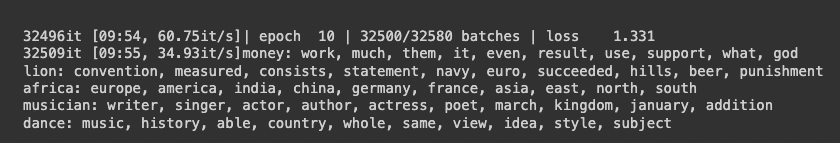

### Results after epoch two:

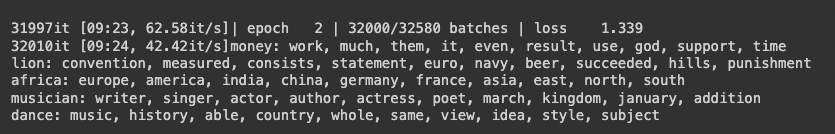